<a href="https://colab.research.google.com/github/mattfarrow1/7331-machine-learning-1/blob/main/Labs/MiniProject_Group4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Mini-Project: SVM & Logistic Regression Classification

Matt Farrow, Amber Clark, Blake Freeman, Megan Ball

## **2015 Flight Delays and Cancellations**
Data Source: [Kaggle](https://www.kaggle.com/usdot/flight-delays?select=flights.csv)

Our group's Mini Project uses the same data that we explored during [Lab 1](https://nbviewer.jupyter.org/github/mattfarrow1/7331-machine-learning-1/blob/main/Labs/Lab1_Group4.ipynb), which you'll recall came from the U.S. Department of Transportation's Bureau of Transportation Statistics and "tracks the on-time performance of domestic flights operated by large air carriers" during 2015 [Kaggle](https://www.kaggle.com/usdot/flight-delays). 

Our logistic regression and support vector machine models will focus on classifying flights using arrival delay as our response variable. As we noted in Lab 1's Business Understanding section, "Arrival delay serves as the total delay experienced by the flight and accounts for previous delays as well as time that pilots were able to make up in the air."

## 1. Logistic Regression & Support Vector Machine Models

> **[50 points]** Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use.

### 1.1 Setup & Load Data

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from datetime import datetime
import altair as alt

# Due to the way these columns are formatted, we want to keep the leading zeros during our import. 
# Later on we will convert them to a time format.
dtype_t = {'SCHEDULED_DEPARTURE': str,
           'DEPARTURE_TIME': str,
           'WHEELS_OFF': str,
           'SCHEDULED_TIME': str,
           'WHEELS_ON': str,
           'SCHEDULED_ARRIVAL': str,
           'ARRIVAL_TIME': str
          }

# Read in the data directly
airlines = pd.read_csv('../Data/airlines.csv')
airports = pd.read_csv('../Data/airports.csv')
flights  = pd.read_csv('../Data/flights.csv', dtype = dtype_t)

# Read in the data directly from GitHub
# airlines = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airlines.csv')
# airports = pd.read_csv('https://raw.githubusercontent.com/mattfarrow1/7331-machine-learning-1/main/Data/airports.csv')
# flights  = pd.read_csv('https://media.githubusercontent.com/media/mattfarrow1/7331-machine-learning-1/main/Data/flights.csv', dtype = dtype_t)

/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3166: DtypeWarning: Columns (7,8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [2]:
# Rename columns in preparation for merge
airlines.rename(columns={'IATA_CODE': 'AIRLINE_CODE'}, inplace=True)
flights.rename(columns={'AIRLINE': 'AIRLINE_CODE'}, inplace=True)

# Merge data together
df = pd.merge(flights, airlines, on='AIRLINE_CODE', how = 'left')

# Convert string columns to datetime
cols = ["WHEELS_OFF",  
        "WHEELS_ON"] 
df[cols] = df[cols].apply(pd.to_datetime, format = '%H%M', errors='coerce')

# Convert time to numeric for binning of the other times
cols = ["SCHEDULED_DEPARTURE", 
        "DEPARTURE_TIME", 
        "SCHEDULED_ARRIVAL", 
        "ARRIVAL_TIME"]
df[cols] = df[cols].apply(pd.to_numeric)

### 1.2 Create New Variables

The data contains several timestamp and continuous variables that add additional complexity. In order to simplify the data, we created buckets to analyze similar attributes together. 

We first convert `SCHEDULED_DEPARTURE`, `DEPARTURE_TIME`, and `SCHEDULED_ARRIVAL` into buckets based on their timestamp. Because we are trying to predict arrivals we would not have access to the `ARRIVAL_TIME` data.

- **Overnight**: 12:00am - 4:00am
- **Morning**: 4:00am - 11:00am
- **Afternoon**: 11:00am - 4:00pm
- **Evening**: 4:00pm - 12:00am

[Flight] `DISTANCE` is also divided into buckets.

- **Short**: 1-99 miles
- **Medium**: 100-999 miles
- **Long**: 1,000+ miles

In [3]:
# Convert times into buckets for morning, afternoon, and evening as most models cannot handle timestamps.
cut_labels = ['overnight', 'morning', 'afternoon', 'evening']
cut_bins = [0, 400, 1100, 1600, 2359]

df['SCHED_DEPARTURE_TIME'] = pd.cut(df['SCHEDULED_DEPARTURE'], 
                                    bins=cut_bins, 
                                    labels=cut_labels, 
                                    include_lowest=True)
df['ACTUAL_DEPARTURE_TIME'] = pd.cut(df['DEPARTURE_TIME'], 
                                     bins=cut_bins, 
                                     labels=cut_labels, 
                                     include_lowest=True)
df['SCHED_ARRIVAL_TIME'] = pd.cut(df['SCHEDULED_ARRIVAL'], 
                                  bins=cut_bins, 
                                  labels=cut_labels, 
                                  include_lowest=True)

# Bucket Flight Distance
distance_labels = ['Short', 'Medium', 'Long']
distance_bins   = [1, 100, 1000, np.inf]
df['DISTANCE_BUCKET'] = pd.cut(df['DISTANCE'],
                               bins=distance_bins,
                               labels=distance_labels)

# Look at our data with the buckets
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,...,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,DISTANCE_BUCKET
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,...,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,overnight,evening,morning,Long
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,...,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,Long
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,...,NaN,NaN,NaN,NaN,NaN,US Airways Inc.,overnight,overnight,morning,Long
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,...,NaN,NaN,NaN,NaN,NaN,American Airlines Inc.,overnight,overnight,morning,Long
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,...,NaN,NaN,NaN,NaN,NaN,Alaska Airlines Inc.,overnight,overnight,overnight,Long


In [4]:
# Check how many of each bin we have
sched_depart = df['SCHED_DEPARTURE_TIME'].value_counts()
actual_depart = df['ACTUAL_DEPARTURE_TIME'].value_counts()
sched_arrival = df['SCHED_ARRIVAL_TIME'].value_counts()
dist_bucket = df['DISTANCE_BUCKET'].value_counts()

print(sched_depart, '\n\n', actual_depart, '\n\n', sched_arrival, '\n\n', dist_bucket)

morning      2056248
evening      1971869
afternoon    1768922
overnight      22040
Name: SCHED_DEPARTURE_TIME, dtype: int64 

 evening      1999032
morning      1978882
afternoon    1716939
overnight      37560
Name: ACTUAL_DEPARTURE_TIME, dtype: int64 

 evening      2676736
afternoon    1735865
morning      1317709
overnight      88767
Name: SCHED_ARRIVAL_TIME, dtype: int64 

 Medium    4102644
Long      1646627
Short       69808
Name: DISTANCE_BUCKET, dtype: int64


### 1.3 Missing Values

In [5]:
# Convert missing values to 'N' for 'N/A'
df['CANCELLATION_REASON'] = df['CANCELLATION_REASON'].fillna('N')

# Update missing values in times to 0. 
# Will be updating times to a binary (1 = yes action happened, 0 = no action happened)
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].fillna(0)

# Change all non-null values to 1
df.loc[(df.DEPARTURE_TIME != '0'), 'DEPARTURE_TIME'] = 1

# Change column name to 'DEPARTED'
df.rename(columns={'DEPARTURE_TIME': 'DEPARTED'}, inplace=True)

# Update remaining columns using same logic
cols = ['WHEELS_OFF','WHEELS_ON','ARRIVAL_TIME']
df[cols] = df[cols].fillna(0)
df.loc[(df.WHEELS_OFF != '0'), 'WHEELS_OFF'] = 1
df.loc[(df.WHEELS_ON != '0'), 'WHEELS_ON'] = 1
df.loc[(df.ARRIVAL_TIME != '0'), 'ARRIVAL_TIME'] = 1
df.rename(columns={'ARRIVAL_TIME': 'ARRIVED'}, inplace=True)

# Fill missing values with 0
cols = ['AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY','LATE_AIRCRAFT_DELAY','WEATHER_DELAY']
df[cols] = df[cols].fillna(0)

# Change remaining null values to 0 if flight was cancelled
df.loc[(df.CANCELLED == 1), ('DEPARTURE_DELAY', 'TAXI_OUT', 'ELAPSED_TIME','AIR_TIME','TAXI_IN','ARRIVAL_DELAY')] = 0

# Remove remaining null values
df = df.dropna()

### 1.4 Log Transformations

As we discovered during Lab 1, the `DEPARTURE_DELAY`, `ARRIVAL_DELAY`, `DISTANCE`, `TAXI_IN`, `ELAPSED_TIME`, and `AIR_TIME` variables are siginificantly right-skewed with a large number of outliers. In order to normalize these values, we did a log transformation.

In [6]:
# Log transformation keeping the 0 in the data sets 
df["DEPARTURE_DELAY_log"] = df["DEPARTURE_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["ARRIVAL_DELAY_Log"]   = df["ARRIVAL_DELAY"].map(lambda i: np.log1p(i) if i > 0 else 0)
df["DISTANCE_log"]        = df["DISTANCE"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["TAXI_IN_Log"]         = df["TAXI_IN"].map(lambda i: np.log1p(i) if i > 0 else 0)
df["ELAPSED_TIME_log"]    = df["ELAPSED_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0) 
df["AIR_TIME_log"]        = df["AIR_TIME"].map(lambda i: np.log1p(i) if i > 0 else 0) 

In [7]:
# These columns required log transformations to normalize the data therefore removed prior variable.
col_to_drop = ['DEPARTURE_DELAY','ARRIVAL_DELAY','DISTANCE','TAXI_IN',
               'ELAPSED_TIME', 'AIR_TIME']
df = df.drop(columns = col_to_drop)

In [8]:
# Check our current columns
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5717223 entries, 0 to 5819078
Data columns (total 36 columns):
 #   Column                 Dtype   
---  ------                 -----   
 0   YEAR                   int64   
 1   MONTH                  int64   
 2   DAY                    int64   
 3   DAY_OF_WEEK            int64   
 4   AIRLINE_CODE           object  
 5   FLIGHT_NUMBER          int64   
 6   TAIL_NUMBER            object  
 7   ORIGIN_AIRPORT         object  
 8   DESTINATION_AIRPORT    object  
 9   SCHEDULED_DEPARTURE    int64   
 10  DEPARTED               float64 
 11  TAXI_OUT               float64 
 12  WHEELS_OFF             object  
 13  SCHEDULED_TIME         object  
 14  WHEELS_ON              object  
 15  SCHEDULED_ARRIVAL      int64   
 16  ARRIVED                float64 
 17  DIVERTED               int64   
 18  CANCELLED              int64   
 19  CANCELLATION_REASON    object  
 20  AIR_SYSTEM_DELAY       float64 
 21  SECURITY_DELAY         float64 

In [9]:
# Look at the head of all columns
pd.set_option('display.max_columns', None)
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,WHEELS_ON,SCHEDULED_ARRIVAL,ARRIVED,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,DISTANCE_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,1.0,21.0,1,205,1,430,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,evening,morning,Long,0.0,0.000000,7.278629,1.609438,5.273000,5.135798
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,1.0,12.0,1,280,1,750,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,Long,0.0,0.000000,7.754053,1.609438,5.634790,5.575949
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,1.0,16.0,1,286,1,806,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,US Airways Inc.,overnight,overnight,morning,Long,0.0,1.791759,7.739359,2.484907,5.683580,5.587249
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,1.0,15.0,1,285,1,805,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,Long,0.0,0.000000,7.759187,2.197225,5.641907,5.556828
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,1.0,11.0,1,235,1,320,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,overnight,overnight,Long,0.0,0.000000,7.278629,1.791759,5.375278,5.298317


In [10]:
# Convert scheduled time to be a numeric instead of an object.
df['SCHEDULED_TIME'] = pd.to_numeric(df['SCHEDULED_TIME'])

### 1.5 Remove Non-Cancelled Flights

Flights that are cancelled will, by their nature, not have an arrival delay. Therefore we remove those so that we are left with only the flights that were completed. 

In [11]:
df = df[df.CANCELLED == 0]

In [12]:
df.shape

(5713499, 36)

In [13]:
df.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTED,TAXI_OUT,WHEELS_OFF,SCHEDULED_TIME,WHEELS_ON,SCHEDULED_ARRIVAL,ARRIVED,DIVERTED,CANCELLED,CANCELLATION_REASON,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,AIRLINE,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,DISTANCE_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log
0,2015,1,1,4,AS,98,N407AS,ANC,SEA,5,1.0,21.0,1,205,1,430,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,evening,morning,Long,0.0,0.000000,7.278629,1.609438,5.273000,5.135798
1,2015,1,1,4,AA,2336,N3KUAA,LAX,PBI,10,1.0,12.0,1,280,1,750,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,Long,0.0,0.000000,7.754053,1.609438,5.634790,5.575949
2,2015,1,1,4,US,840,N171US,SFO,CLT,20,1.0,16.0,1,286,1,806,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,US Airways Inc.,overnight,overnight,morning,Long,0.0,1.791759,7.739359,2.484907,5.683580,5.587249
3,2015,1,1,4,AA,258,N3HYAA,LAX,MIA,20,1.0,15.0,1,285,1,805,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,American Airlines Inc.,overnight,overnight,morning,Long,0.0,0.000000,7.759187,2.197225,5.641907,5.556828
4,2015,1,1,4,AS,135,N527AS,SEA,ANC,25,1.0,11.0,1,235,1,320,1.0,0,0,N,0.0,0.0,0.0,0.0,0.0,Alaska Airlines Inc.,overnight,overnight,overnight,Long,0.0,0.000000,7.278629,1.791759,5.375278,5.298317


### 1.6 Feature Removals

Here we remove redundant columns to further reduce the data size. Columns that are being removed:
- `YEAR`: All rows are from 2015, no need to include this.
- `AIRLINE`: We have `AIRLINE_CODE` which is the same information
- `SCHEDULED_DEPARTURE` and `SCHEDULED_ARRIVAL`
- `CANCELLATION_REASON` and `CANCELLED`: We are looking at delays only so do not need cancellation details.
- `WHEELS_ON` and `WHEELS_OFF`: We made these binary instead of a time stamp, but this is no longer needed when we are looking at flights being delayed, as these values will all be `1`
- `DEPARTED` and `ARRIVED`: Again, these are binary values and are not needed as all will be equal to `1` after removing the cancelled flights

In [14]:
col_to_drop = ['YEAR','AIRLINE','SCHEDULED_DEPARTURE','SCHEDULED_ARRIVAL',
               'CANCELLED', 'CANCELLATION_REASON', 'WHEELS_ON', 'WHEELS_OFF', 
               'ARRIVED', 'DEPARTED']
df = df.drop(columns = col_to_drop)

In [15]:
df.head()

,MONTH,DAY,DAY_OF_WEEK,AIRLINE_CODE,FLIGHT_NUMBER,TAIL_NUMBER,ORIGIN_AIRPORT,DESTINATION_AIRPORT,TAXI_OUT,SCHEDULED_TIME,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,SCHED_DEPARTURE_TIME,ACTUAL_DEPARTURE_TIME,SCHED_ARRIVAL_TIME,DISTANCE_BUCKET,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log
0,1,1,4,AS,98,N407AS,ANC,SEA,21.0,205,0,0.0,0.0,0.0,0.0,0.0,overnight,evening,morning,Long,0.0,0.000000,7.278629,1.609438,5.273000,5.135798
1,1,1,4,AA,2336,N3KUAA,LAX,PBI,12.0,280,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,Long,0.0,0.000000,7.754053,1.609438,5.634790,5.575949
2,1,1,4,US,840,N171US,SFO,CLT,16.0,286,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,Long,0.0,1.791759,7.739359,2.484907,5.683580,5.587249
3,1,1,4,AA,258,N3HYAA,LAX,MIA,15.0,285,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,morning,Long,0.0,0.000000,7.759187,2.197225,5.641907,5.556828
4,1,1,4,AS,135,N527AS,SEA,ANC,11.0,235,0,0.0,0.0,0.0,0.0,0.0,overnight,overnight,overnight,Long,0.0,0.000000,7.278629,1.791759,5.375278,5.298317


### 1.7 Encoding

We know that `TAIL_NUMBER`, `ORIGIN_AIRPORT`, and `DESTINATION_AIRPORT` contain a large number of unique values. Before proceeding, we wanted to check and see exactly how many of each we had.

In [16]:
print(df['TAIL_NUMBER'].value_counts())
print(df['ORIGIN_AIRPORT'].value_counts())
print(df['DESTINATION_AIRPORT'].value_counts())

N480HA    3765
N484HA    3722
N488HA    3720
N493HA    3582
N478HA    3575
          ... 
N121UA       1
N175UA       1
N852NW       1
N860NW       1
N7LBAA       1
Name: TAIL_NUMBER, Length: 4896, dtype: int64
ATL      343479
ORD      276544
DFW      232635
DEN      193345
LAX      191939
          ...  
14025         1
11097         1
14222         1
15497         1
13502         1
Name: ORIGIN_AIRPORT, Length: 929, dtype: int64
ATL      343052
ORD      275834
DFW      231744
DEN      193030
LAX      192128
          ...  
15497         1
14222         1
13459         1
10666         1
11097         1
Name: DESTINATION_AIRPORT, Length: 929, dtype: int64


We have 4,896 different airplanes (`TAIL_NUMBER`) and 929 different airports (`ORIGIN_AIRPORT` and `DESTINATION_AIRPORT`). If we one-hot encode all of these, it would create way too many columns. We would also run the risk of not including a specific airport or tail number in our training data set which would cause an error if it is in our test data set. For that reason, let's set the cut-off to a minimum occurrence of 5 for tail numbers and 10 for the origin and destination airports so that we have a greater likelihood of including it within either the train or test set.

In [17]:
df = df[df.groupby('TAIL_NUMBER').TAIL_NUMBER.transform(len) > 4]
df = df[df.groupby('ORIGIN_AIRPORT').ORIGIN_AIRPORT.transform(len) > 9]
df = df[df.groupby('DESTINATION_AIRPORT').DESTINATION_AIRPORT.transform(len) > 9]
print(df['TAIL_NUMBER'].value_counts())
print(df['ORIGIN_AIRPORT'].value_counts())
print(df['DESTINATION_AIRPORT'].value_counts())

N480HA    3765
N484HA    3722
N488HA    3720
N493HA    3582
N478HA    3575
          ... 
N119UA       5
N74007       5
N7LKAA       5
N839MH       5
N705DN       5
Name: TAIL_NUMBER, Length: 4844, dtype: int64
ATL      343459
ORD      276537
DFW      232632
DEN      193345
LAX      191919
          ...  
11778        10
12884        10
13061        10
11624        10
12819         8
Name: ORIGIN_AIRPORT, Length: 809, dtype: int64
ATL      343032
ORD      275825
DFW      231738
DEN      193030
LAX      192110
          ...  
12003        10
11778        10
16218        10
11146        10
10208        10
Name: DESTINATION_AIRPORT, Length: 808, dtype: int64


This now reduces to 4,844 unique tail numbers, 809 unique origin airports, and 808 unique destination airports. Hopefully a minimum count of 5 does not give us errors later on.

Next, we will encode these variables. We are not one-hot encoding as there are still too many values. We know this will add some ordinality to the variables but it is simply not feasible to have 4000+ columns on a 5 million row data set without moving to a cloud-based solution.

In [18]:
%%time

from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

df['ORIGIN_AIRPORT_encode'] = labelencoder.fit_transform(df['ORIGIN_AIRPORT'].astype('str'))
df2 = df[['ORIGIN_AIRPORT','ORIGIN_AIRPORT_encode']]
df2 = df2.drop_duplicates(subset=['ORIGIN_AIRPORT'], keep='last')

df2.rename(columns={'ORIGIN_AIRPORT': 'DESTINATION_AIRPORT'}, inplace=True)
df2.rename(columns={'ORIGIN_AIRPORT_encode': 'DESTINATION_AIRPORT_encode'}, inplace=True)

df = pd.merge(df, df2, on='DESTINATION_AIRPORT', how = 'left')
df.dropna(subset = ["DESTINATION_AIRPORT_encode"], inplace=True)

df['TAIL_NUMBER_encode'] = labelencoder.fit_transform(df['TAIL_NUMBER'])

# Drop original columns
col_to_drop = ['TAIL_NUMBER', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT']
df = df.drop(columns = col_to_drop)

CPU times: user 6.25 s, sys: 1.53 s, total: 7.78 s
Wall time: 7.97 s


For the remaining categorical variables, we can one-hot encode as the number of unique values is significantly fewer.

In [19]:
%%time

categorical_columns = ['AIRLINE_CODE', 'SCHED_DEPARTURE_TIME', 
                       'ACTUAL_DEPARTURE_TIME','SCHED_ARRIVAL_TIME',
                       'DISTANCE_BUCKET']

for column in categorical_columns:
  tempdf = pd.get_dummies(df[categorical_columns], prefix = categorical_columns)
  df_OHE = pd.merge(
      left = df,
      right = tempdf,
      left_index=True,
      right_index=True
  )
  df_OHE = df_OHE.drop(columns = categorical_columns)

df_OHE.head()

CPU times: user 8.26 s, sys: 2.83 s, total: 11.1 s
Wall time: 11.1 s


,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAXI_OUT,SCHEDULED_TIME,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DEPARTURE_DELAY_log,ARRIVAL_DELAY_Log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log,ORIGIN_AIRPORT_encode,DESTINATION_AIRPORT_encode,TAIL_NUMBER_encode,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,AIRLINE_CODE_EV,AIRLINE_CODE_F9,AIRLINE_CODE_HA,AIRLINE_CODE_MQ,AIRLINE_CODE_NK,AIRLINE_CODE_OO,AIRLINE_CODE_UA,AIRLINE_CODE_US,AIRLINE_CODE_VX,AIRLINE_CODE_WN,SCHED_DEPARTURE_TIME_overnight,SCHED_DEPARTURE_TIME_morning,SCHED_DEPARTURE_TIME_afternoon,SCHED_DEPARTURE_TIME_evening,ACTUAL_DEPARTURE_TIME_overnight,ACTUAL_DEPARTURE_TIME_morning,ACTUAL_DEPARTURE_TIME_afternoon,ACTUAL_DEPARTURE_TIME_evening,SCHED_ARRIVAL_TIME_overnight,SCHED_ARRIVAL_TIME_morning,SCHED_ARRIVAL_TIME_afternoon,SCHED_ARRIVAL_TIME_evening,DISTANCE_BUCKET_Short,DISTANCE_BUCKET_Medium,DISTANCE_BUCKET_Long
0,1,1,4,98,21.0,205,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.278629,1.609438,5.273000,5.135798,319,579.0,1610,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1
1,1,1,4,2336,12.0,280,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.754053,1.609438,5.634790,5.575949,478,537.0,1544,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
2,1,1,4,840,16.0,286,0,0.0,0.0,0.0,0.0,0.0,0.0,1.791759,7.739359,2.484907,5.683580,5.587249,580,368.0,415,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
3,1,1,4,258,15.0,285,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.759187,2.197225,5.641907,5.556828,478,505.0,1504,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1
4,1,1,4,135,11.0,235,0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,7.278629,1.791759,5.375278,5.298317,579,319.0,2119,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1


In [20]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 50 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   MONTH                            int64  
 1   DAY                              int64  
 2   DAY_OF_WEEK                      int64  
 3   FLIGHT_NUMBER                    int64  
 4   TAXI_OUT                         float64
 5   SCHEDULED_TIME                   int64  
 6   DIVERTED                         int64  
 7   AIR_SYSTEM_DELAY                 float64
 8   SECURITY_DELAY                   float64
 9   AIRLINE_DELAY                    float64
 10  LATE_AIRCRAFT_DELAY              float64
 11  WEATHER_DELAY                    float64
 12  DEPARTURE_DELAY_log              float64
 13  ARRIVAL_DELAY_Log                float64
 14  DISTANCE_log                     float64
 15  TAXI_IN_Log                      float64
 16  ELAPSED_TIME_log                 float64
 17  AIR_TIME

### 1.8 Create Response Variable

In [21]:
# Create a new column where the arrival_delay > 0 means it's delayed(=1) and if <= 0 it's not delayed(=0)
get_delay = lambda x: 0 if x <= 0 else 1
df_OHE['DELAYED'] = df_OHE.ARRIVAL_DELAY_Log.apply(get_delay)
df_OHE = df_OHE.drop(columns = 'ARRIVAL_DELAY_Log')
df_OHE.head()

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAXI_OUT,SCHEDULED_TIME,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DEPARTURE_DELAY_log,DISTANCE_log,TAXI_IN_Log,ELAPSED_TIME_log,AIR_TIME_log,ORIGIN_AIRPORT_encode,DESTINATION_AIRPORT_encode,TAIL_NUMBER_encode,AIRLINE_CODE_AA,AIRLINE_CODE_AS,AIRLINE_CODE_B6,AIRLINE_CODE_DL,AIRLINE_CODE_EV,AIRLINE_CODE_F9,AIRLINE_CODE_HA,AIRLINE_CODE_MQ,AIRLINE_CODE_NK,AIRLINE_CODE_OO,AIRLINE_CODE_UA,AIRLINE_CODE_US,AIRLINE_CODE_VX,AIRLINE_CODE_WN,SCHED_DEPARTURE_TIME_overnight,SCHED_DEPARTURE_TIME_morning,SCHED_DEPARTURE_TIME_afternoon,SCHED_DEPARTURE_TIME_evening,ACTUAL_DEPARTURE_TIME_overnight,ACTUAL_DEPARTURE_TIME_morning,ACTUAL_DEPARTURE_TIME_afternoon,ACTUAL_DEPARTURE_TIME_evening,SCHED_ARRIVAL_TIME_overnight,SCHED_ARRIVAL_TIME_morning,SCHED_ARRIVAL_TIME_afternoon,SCHED_ARRIVAL_TIME_evening,DISTANCE_BUCKET_Short,DISTANCE_BUCKET_Medium,DISTANCE_BUCKET_Long,DELAYED
0,1,1,4,98,21.0,205,0,0.0,0.0,0.0,0.0,0.0,0.0,7.278629,1.609438,5.273000,5.135798,319,579.0,1610,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0
1,1,1,4,2336,12.0,280,0,0.0,0.0,0.0,0.0,0.0,0.0,7.754053,1.609438,5.634790,5.575949,478,537.0,1544,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
2,1,1,4,840,16.0,286,0,0.0,0.0,0.0,0.0,0.0,0.0,7.739359,2.484907,5.683580,5.587249,580,368.0,415,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,1
3,1,1,4,258,15.0,285,0,0.0,0.0,0.0,0.0,0.0,0.0,7.759187,2.197225,5.641907,5.556828,478,505.0,1504,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,0,0,1,0
4,1,1,4,135,11.0,235,0,0.0,0.0,0.0,0.0,0.0,0.0,7.278629,1.791759,5.375278,5.298317,579,319.0,2119,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,1,0


In [22]:
# Check the response variable distribution
df_OHE['DELAYED'].value_counts()

0    3626052
1    2086178
Name: DELAYED, dtype: int64

### 1.9 Check Correlations

<AxesSubplot:>

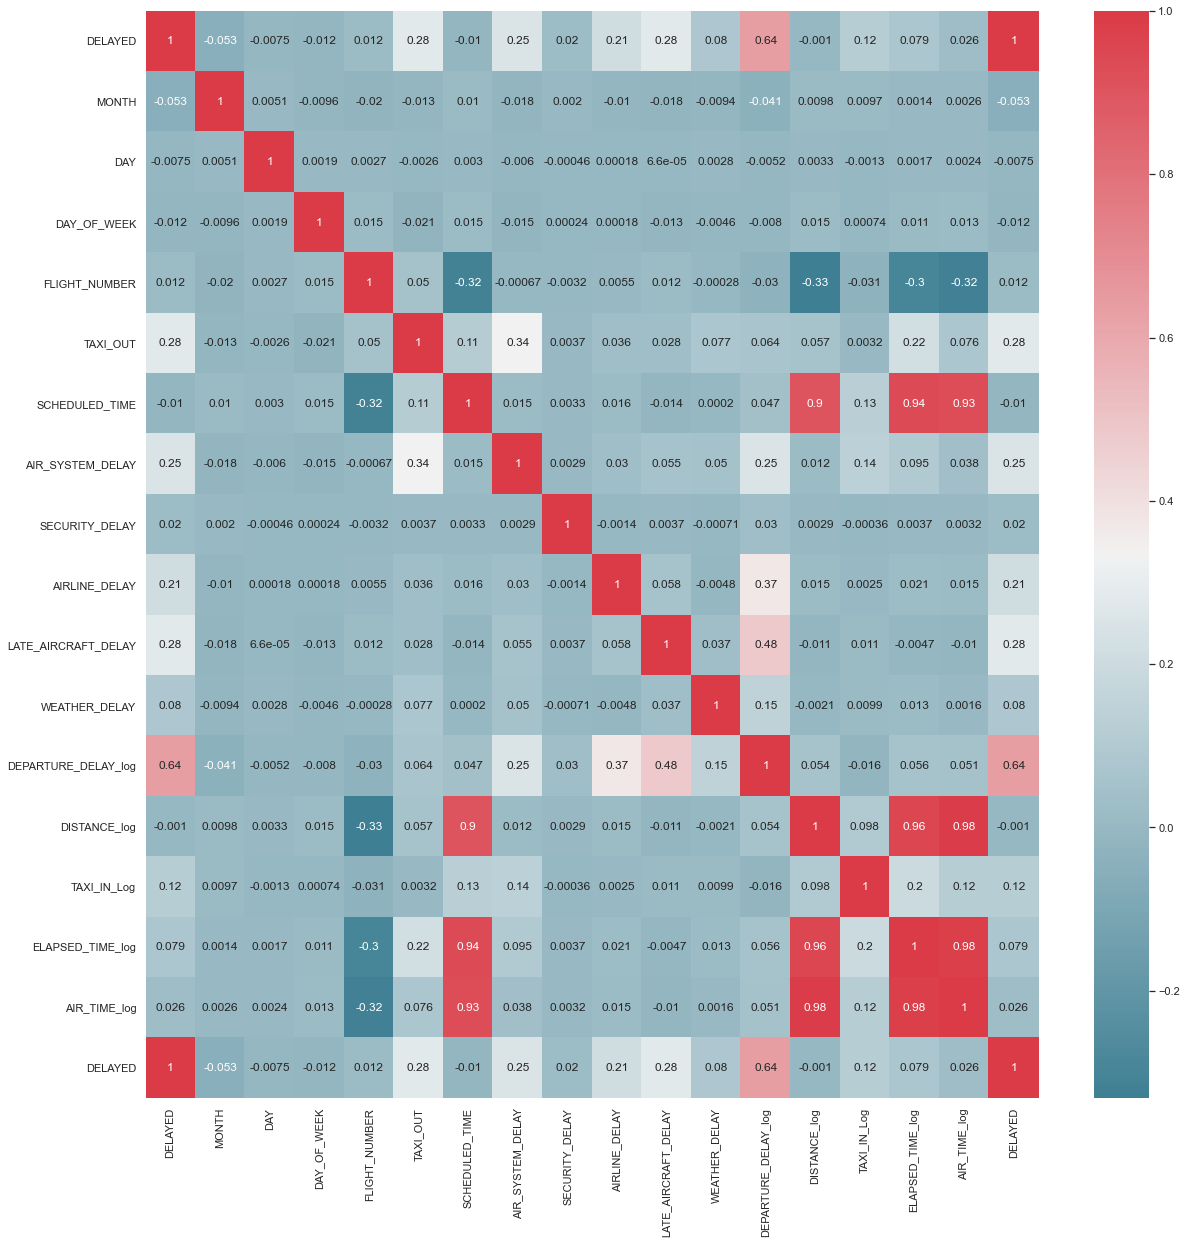

In [23]:
# Examine correlation visually using Seaborn. 
# (Code adapted from 02. Data Visualization.ipynb)

cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

# Subset for response and continuous variables
num = df_OHE[['DELAYED', 'MONTH', 'DAY','DAY_OF_WEEK','FLIGHT_NUMBER',
          'TAXI_OUT','SCHEDULED_TIME',
           'AIR_SYSTEM_DELAY','SECURITY_DELAY','AIRLINE_DELAY',
          'LATE_AIRCRAFT_DELAY','WEATHER_DELAY', 'DEPARTURE_DELAY_log',
          'DISTANCE_log', 'TAXI_IN_Log','ELAPSED_TIME_log',
          'AIR_TIME_log','DELAYED']]

# Create heatmap
sns.heatmap(num.corr(), cmap=cmap, annot = True)

`SCHEDULED_TIME`, `ELAPSED_TIME_log`, `AIR_TIME_log`, `DISTANCE_log` are all highly correlated. For the purposes here we want to only keep `DISTANCE_log`, the decision to keep this variable was that we would not know the Air Time and Elapsed Time since we are trying to predict if the plane would be delayed prior to flight and distance would always be known. 

In [24]:
# Drop SCHEDULED_TIME, ELAPSED_TIME, AIR_TIME, and their log versions as well as DEPARTURE_DELAY
col_to_drop2 = ['SCHEDULED_TIME', 'ELAPSED_TIME_log', 'AIR_TIME_log']
df_OHE = df_OHE.drop(columns = col_to_drop2)

<AxesSubplot:>

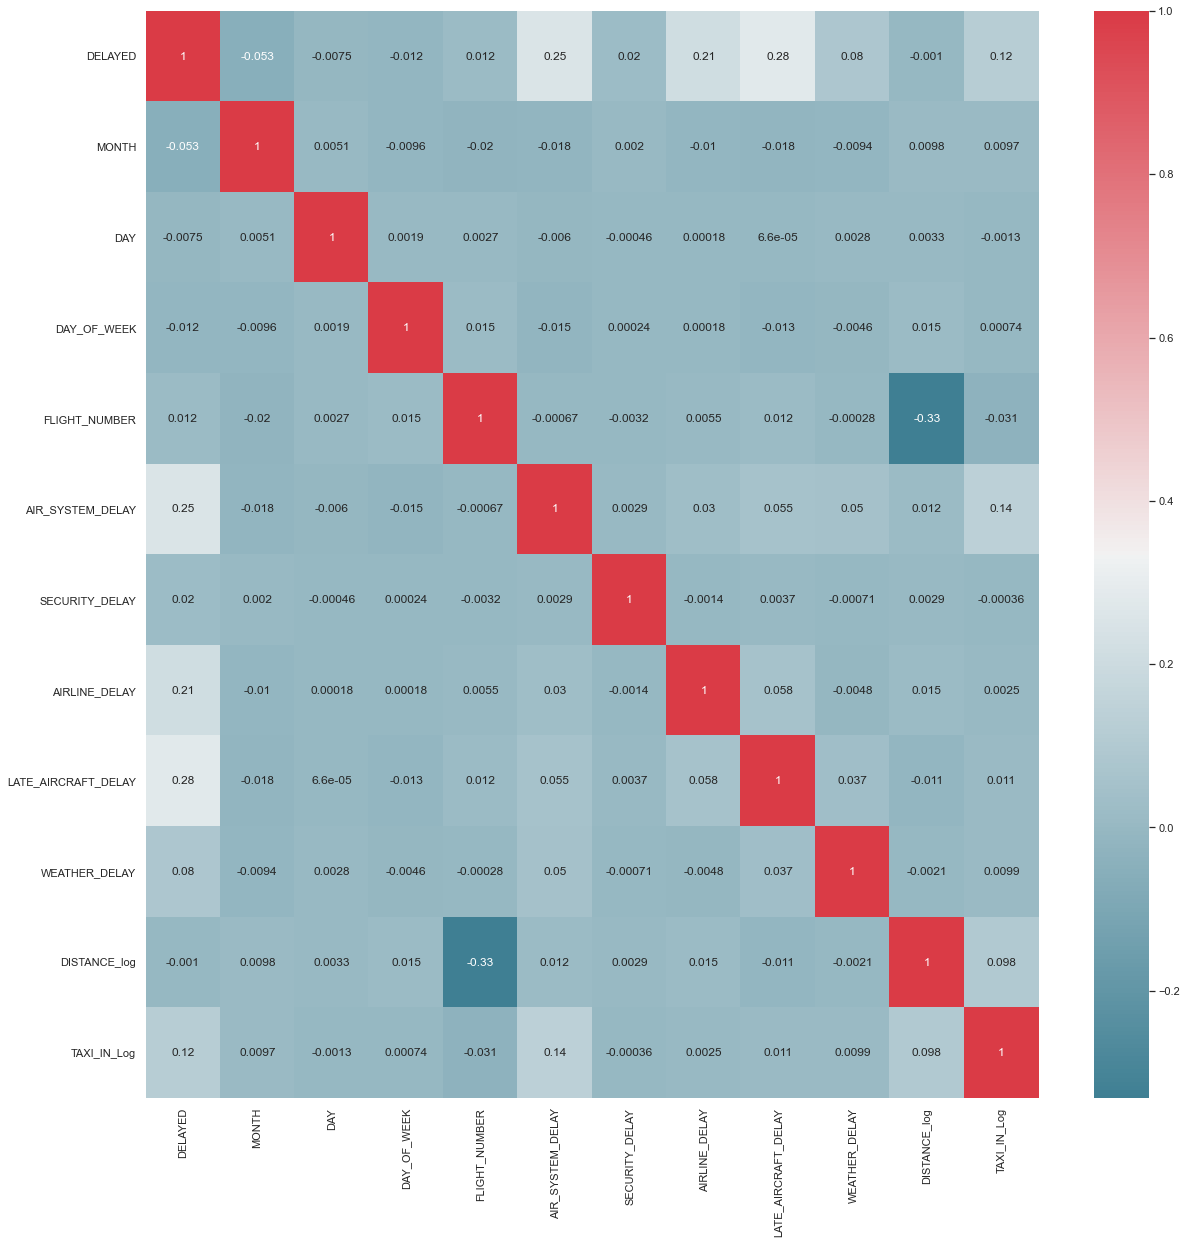

In [25]:
# Examine correlation visually using Seaborn. (Code adapted from 02. Data Visualization.ipynb)
cmap = sns.diverging_palette(220, 10, as_cmap=True)

sns.set(style = "darkgrid") # one of the many styles to plot using

f, ax = plt.subplots(figsize = (20, 20))

# Subset for the remaining continuous variables
num = df_OHE[['DELAYED', 'MONTH', 'DAY','DAY_OF_WEEK','FLIGHT_NUMBER',
          'AIR_SYSTEM_DELAY',
          'SECURITY_DELAY','AIRLINE_DELAY',
          'LATE_AIRCRAFT_DELAY','WEATHER_DELAY',
         'DISTANCE_log', 'TAXI_IN_Log']]

# Create heatmap
sns.heatmap(num.corr(), cmap=cmap, annot = True)

In [26]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 47 columns):
 #   Column                           Dtype  
---  ------                           -----  
 0   MONTH                            int64  
 1   DAY                              int64  
 2   DAY_OF_WEEK                      int64  
 3   FLIGHT_NUMBER                    int64  
 4   TAXI_OUT                         float64
 5   DIVERTED                         int64  
 6   AIR_SYSTEM_DELAY                 float64
 7   SECURITY_DELAY                   float64
 8   AIRLINE_DELAY                    float64
 9   LATE_AIRCRAFT_DELAY              float64
 10  WEATHER_DELAY                    float64
 11  DEPARTURE_DELAY_log              float64
 12  DISTANCE_log                     float64
 13  TAXI_IN_Log                      float64
 14  ORIGIN_AIRPORT_encode            int64  
 15  DESTINATION_AIRPORT_encode       float64
 16  TAIL_NUMBER_encode               int64  
 17  AIRLINE_

In [27]:
# Get the location of the `DELAYED` column for use in VIF below
df_OHE.columns.get_loc('DELAYED')

46

In [28]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
  
# VIF dataframe
X = df_OHE.iloc[:, 0:45]
X['Intercept'] = 1
  
# calculating VIF for each feature
vif = pd.DataFrame()
vif["variables"] = X.columns
vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
  
print(vif)

/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - self.ssr/self.centered_tss
/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/outliers_influence.py:193: RuntimeWarning: divide by zero encountered in double_scalars
  vif = 1. / (1. - r_squared_i)


                          variables       VIF
0                             MONTH  1.107417
1                               DAY  1.000217
2                       DAY_OF_WEEK  1.003048
3                     FLIGHT_NUMBER  3.576430
4                          TAXI_OUT  1.255616
5                          DIVERTED       NaN
6                  AIR_SYSTEM_DELAY  1.281466
7                    SECURITY_DELAY  1.001717
8                     AIRLINE_DELAY  1.253206
9               LATE_AIRCRAFT_DELAY  1.417720
10                    WEATHER_DELAY  1.041128
11              DEPARTURE_DELAY_log  1.862277
12                     DISTANCE_log  2.734744
13                      TAXI_IN_Log  1.116214
14            ORIGIN_AIRPORT_encode  1.405710
15       DESTINATION_AIRPORT_encode  1.415366
16               TAIL_NUMBER_encode  1.151381
17                  AIRLINE_CODE_AA       inf
18                  AIRLINE_CODE_AS       inf
19                  AIRLINE_CODE_B6       inf
20                  AIRLINE_CODE_D

/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1715: RuntimeWarning: divide by zero encountered in double_scalars
  return 1 - self.ssr/self.centered_tss


The `AIRLINE_CODE_`, `SCHED_DEPARTURE_TIME_`, `ACTUAL_DEPARTURE_TIME_`, and `SCHED_ARRIVAL_TIME_` one-hot encodings are returning perfect multicollinearity so we'll remove one of each and re-run the VIF. After thinking this through, it makes sense that the actual departure and arrival times are a dead giveaway for delays. Same with our other delay types (`AIR_SYSTEM_DELAY`, `SECURITY_DELAY`, `AIRLINE_DELAY`, `LATE_AIRCRAFT_DELAY`, `WEATHER_DELAY`, and ARRIVAL_DELAY buckets). Logically, the airline code and the scheduled times shouldn't impact our VIF, so let's remove the delay types as well.

In [29]:
features = df_OHE.iloc[:,:12]
features

,MONTH,DAY,DAY_OF_WEEK,FLIGHT_NUMBER,TAXI_OUT,DIVERTED,AIR_SYSTEM_DELAY,SECURITY_DELAY,AIRLINE_DELAY,LATE_AIRCRAFT_DELAY,WEATHER_DELAY,DEPARTURE_DELAY_log
0,1,1,4,98,21.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
1,1,1,4,2336,12.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
2,1,1,4,840,16.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
3,1,1,4,258,15.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
4,1,1,4,135,11.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
5712235,12,31,4,688,22.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
5712236,12,31,4,745,17.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
5712237,12,31,4,1503,17.0,0,0.0,0.0,0.0,0.0,0.0,0.000000
5712238,12,31,4,333,10.0,0,0.0,0.0,0.0,0.0,0.0,0.000000


In [30]:
# Drop the remaining highly correlated variables DISTANCE, TAXI_IN, ARRIVAL_DELAY, and ARRIVAL_DELAY_Log
col_to_drop4 = ['ACTUAL_DEPARTURE_TIME_morning', 'ACTUAL_DEPARTURE_TIME_afternoon', 'ACTUAL_DEPARTURE_TIME_evening', 'ACTUAL_DEPARTURE_TIME_overnight', 
                 'AIR_SYSTEM_DELAY', 'SECURITY_DELAY', 'AIRLINE_DELAY', 'LATE_AIRCRAFT_DELAY', 'WEATHER_DELAY']
df_OHE = df_OHE.drop(columns = col_to_drop4)

In [31]:
df_OHE.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 38 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   MONTH                           int64  
 1   DAY                             int64  
 2   DAY_OF_WEEK                     int64  
 3   FLIGHT_NUMBER                   int64  
 4   TAXI_OUT                        float64
 5   DIVERTED                        int64  
 6   DEPARTURE_DELAY_log             float64
 7   DISTANCE_log                    float64
 8   TAXI_IN_Log                     float64
 9   ORIGIN_AIRPORT_encode           int64  
 10  DESTINATION_AIRPORT_encode      float64
 11  TAIL_NUMBER_encode              int64  
 12  AIRLINE_CODE_AA                 uint8  
 13  AIRLINE_CODE_AS                 uint8  
 14  AIRLINE_CODE_B6                 uint8  
 15  AIRLINE_CODE_DL                 uint8  
 16  AIRLINE_CODE_EV                 uint8  
 17  AIRLINE_CODE_F9            

### 1.10 Test/Train Split

Our desired variable for classication will be our binary value for delay to determine whether or not a flight was delayed on arrival.

In [32]:
# Prep for the split by moving the response variable to the last column.
cols = list(df_OHE.columns.values) 
cols.pop(cols.index('DELAYED')) 
df_final = df_OHE[cols+['DELAYED']]

In [33]:
df_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5712230 entries, 0 to 5712239
Data columns (total 38 columns):
 #   Column                          Dtype  
---  ------                          -----  
 0   MONTH                           int64  
 1   DAY                             int64  
 2   DAY_OF_WEEK                     int64  
 3   FLIGHT_NUMBER                   int64  
 4   TAXI_OUT                        float64
 5   DIVERTED                        int64  
 6   DEPARTURE_DELAY_log             float64
 7   DISTANCE_log                    float64
 8   TAXI_IN_Log                     float64
 9   ORIGIN_AIRPORT_encode           int64  
 10  DESTINATION_AIRPORT_encode      float64
 11  TAIL_NUMBER_encode              int64  
 12  AIRLINE_CODE_AA                 uint8  
 13  AIRLINE_CODE_AS                 uint8  
 14  AIRLINE_CODE_B6                 uint8  
 15  AIRLINE_CODE_DL                 uint8  
 16  AIRLINE_CODE_EV                 uint8  
 17  AIRLINE_CODE_F9            

In [34]:
from sklearn.model_selection import ShuffleSplit

# We want to predict the X and y data as follows:
if 'DELAYED' in df_final:
    y = df_final['DELAYED'].values # get the labels we want
    # del df_final['DELAYED'] # get rid of the class label
    X = df_final.iloc[:,:-1].values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
# To use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits.
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=10, test_size=0.2, train_size=None)


In [35]:
X.shape

(5712230, 37)

In [36]:
y.shape

(5712230,)

In [37]:
features = list(df_final.iloc[:,:-1])
features

['MONTH',
 'DAY',
 'DAY_OF_WEEK',
 'FLIGHT_NUMBER',
 'TAXI_OUT',
 'DIVERTED',
 'DEPARTURE_DELAY_log',
 'DISTANCE_log',
 'TAXI_IN_Log',
 'ORIGIN_AIRPORT_encode',
 'DESTINATION_AIRPORT_encode',
 'TAIL_NUMBER_encode',
 'AIRLINE_CODE_AA',
 'AIRLINE_CODE_AS',
 'AIRLINE_CODE_B6',
 'AIRLINE_CODE_DL',
 'AIRLINE_CODE_EV',
 'AIRLINE_CODE_F9',
 'AIRLINE_CODE_HA',
 'AIRLINE_CODE_MQ',
 'AIRLINE_CODE_NK',
 'AIRLINE_CODE_OO',
 'AIRLINE_CODE_UA',
 'AIRLINE_CODE_US',
 'AIRLINE_CODE_VX',
 'AIRLINE_CODE_WN',
 'SCHED_DEPARTURE_TIME_overnight',
 'SCHED_DEPARTURE_TIME_morning',
 'SCHED_DEPARTURE_TIME_afternoon',
 'SCHED_DEPARTURE_TIME_evening',
 'SCHED_ARRIVAL_TIME_overnight',
 'SCHED_ARRIVAL_TIME_morning',
 'SCHED_ARRIVAL_TIME_afternoon',
 'SCHED_ARRIVAL_TIME_evening',
 'DISTANCE_BUCKET_Short',
 'DISTANCE_BUCKET_Medium',
 'DISTANCE_BUCKET_Long']

### 1.11 Lasso Regression

In [38]:
# Alternate test/train split for use in lasso regression
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [39]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Define pipeline
pipeline = Pipeline([
                     ('scaler',StandardScaler()),
                     ('model',Lasso())
])

grid = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)}, #test values of alpha from 0.1 to 10
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [40]:
# # Run grid search
# grid.fit(X_train,y_train)

In [41]:
# # Find the best value of alpha
# grid.best_params_

In [42]:
# # Find coefficients
# coefficients = grid.best_estimator_.named_steps['model'].coef_
# coefficients

In [43]:
# # Find the most important features
# np.array(features)[coefficients > 0]

The above code is commented out due to the length of time LASSO regression takes to run. Based on previous runs, the only important features in our data set are TAXI-OUT and DEPARTURE_DELAY_log. This is possibly an indicator that our data set for predicting DELAY may not be the best. We do not want to remove all other variables at this point, but this is an interesting finding to keep in mind for the remainder of our analysis. Let's run PCA next to see if it shows any promise for dimension reduction.

### 1.12 PCA

In [44]:
# Standardize the features
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Create the object
scaler = StandardScaler()

# Calculate the mean and standard deviation
scaler.fit(df_final.iloc[:,:-1]) #scale everything except response variable
df_pca_scaled = scaler.transform(df_final.iloc[:,:-1])

# Calculate the PCA that explains 95% of the variance
pca_95 = PCA(n_components=0.95, random_state=2015)
pca_95.fit(df_pca_scaled)
df_pca_95 = pca_95.transform(df_pca_scaled)

# Display the PCA values
np.cumsum(pca_95.explained_variance_ratio_*100)

array([ 8.98904972, 16.87338567, 22.50483458, 27.4868927 , 32.04993396,
       36.02697391, 39.92814594, 43.61029312, 46.91890225, 50.09240714,
       53.23293702, 56.2378112 , 59.23256819, 62.14765254, 65.02618407,
       67.8643804 , 70.67806787, 73.45446262, 76.22395773, 78.98324411,
       81.65217484, 84.24192365, 86.5800357 , 88.72800751, 90.8254909 ,
       92.88294714, 94.87316269, 96.7127538 ])

In this version of our data set, it takes 28 principal components to get up to 95% explained variability.

Text(0, 0.5, 'Explained Variance')

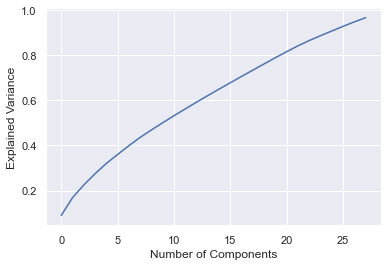

In [45]:
# Plot PCA results
plt.plot(np.cumsum(pca_95.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Explained Variance')

In [46]:
df_post_pca = pd.DataFrame(df_pca_95, columns = ['PC1', 'PC2', 'PC3', 'PC4', 'PC5', 'PC6', 'PC7', 'PC8',
                                                 'PC9', 'PC10', 'PC11', 'PC12', 'PC13', 'PC14', 'PC15',
                                                 'PC16', 'PC17', 'PC18', 'PC19', 'PC20', 'PC21', 'PC22',
                                                 'PC23', 'PC24', 'PC25', 'PC26', 'PC27', 'PC28'])
df_post_pca['Delayed'] = df_final.DELAYED
df_post_pca.head()

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,Delayed
0,3.609769,-2.443451,-1.695949,-1.639898,0.055845,-0.161267,0.911516,0.666445,0.546937,-2.040368,-4.224530,2.959413,9.284651,2.101439,5.238942,0.799259,-3.781516,-1.690615,2.467831,6.107657,7.565242,1.882498,0.373663,-3.377413,-0.139191,0.000205,2.853126,0.035745,0.0
1,3.455453,-2.458344,-1.456305,-1.672021,1.271297,-0.760421,0.140543,0.258987,-1.226247,-1.962383,-3.228313,5.264796,5.705031,1.949376,6.108941,-0.439638,-2.550432,-1.268272,0.160887,7.107252,8.629368,-0.163975,-1.265021,-3.384477,-0.479260,0.658617,1.485193,-0.311974,0.0
2,3.616934,-2.549772,-1.623507,-2.081723,0.806378,0.000110,-0.070049,2.431868,0.290205,0.077004,-4.366121,7.786380,4.918931,2.286673,4.897154,0.123388,-4.131614,-1.379360,2.673682,6.534059,7.890720,-0.866192,0.022693,-2.927653,2.527630,0.346128,1.344184,1.046194,1.0
3,3.935454,-2.600275,-1.532814,-1.229612,1.237222,-0.794676,0.248912,1.024572,-1.654687,-1.759163,-3.116145,5.281418,5.637600,1.982772,6.051377,-0.364234,-2.433270,-1.254712,0.173828,6.933079,8.563683,-0.391714,-0.569587,-3.462834,-0.141799,0.800028,2.112781,-0.272909,0.0
4,4.317083,-1.234068,-1.176625,-1.528833,-0.504365,-0.426565,0.813690,-0.862122,1.022784,-1.347724,-1.196321,4.042615,11.224396,5.873542,0.779014,0.002959,-2.593895,-1.914241,2.277828,7.380133,8.557572,-0.625707,2.000488,-2.327584,-0.577008,-0.154607,2.840544,-0.186741,0.0


Text(0, 0.5, 'Second Principal Component')

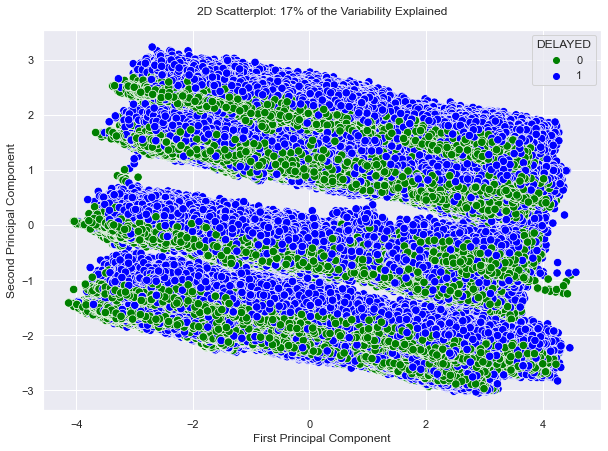

In [47]:
# Plot first two principal components
plt.figure(figsize=(10, 7))
sns.scatterplot(x=df_pca_95[:, 0], y=df_pca_95[:, 1], s=70,
               hue=df_final.DELAYED, palette=['green', 'blue'])

plt.title("2D Scatterplot: 17% of the Variability Explained", pad=15)
plt.xlabel("First Principal Component")
plt.ylabel("Second Principal Component")

This is an interesting plot, but we don't see clear separation for our desired response variable. Therefore, PCA is not useful for dimension reduction on this data set.

### 1.12 Logistic Regression

First, we will run a fairly standard logistic regression model with 3-fold cross validation.

In [48]:
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# Define our model
lr_clf = LogisticRegression(penalty='l2', 
                            C=1.0, 
                            class_weight=None,
                            solver='liblinear')

for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    lr_clf.fit(X[train_indices],y[train_indices])  # train object
    y_hat = lr_clf.predict(X[test_indices]) # get test set precitions

    # print the accuracy and confusion matrix 
    print("====Iteration",iter_num," ====")
    print("accuracy", mt.accuracy_score(y[test_indices],y_hat)) 
    print("confusion matrix\n",mt.confusion_matrix(y[test_indices],y_hat))

====Iteration 0  ====
accuracy 0.8567582187692022
confusion matrix
 [[667215  58317]
 [105329 311585]]
====Iteration 1  ====
accuracy 0.8542486909665752
confusion matrix
 [[665588  59226]
 [107287 310345]]
====Iteration 2  ====
accuracy 0.8539204478811252
confusion matrix
 [[665339  59523]
 [107365 310219]]


Across three separate iterations of 3-fold cross validation gives us around 85% accuracy which is pretty decent. Let's set up a gridsearch to test multiple cost values.

*Update: This crashes due to using all RAM every time so the code has been commented out.*

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

#define pipeline
#pipeline = Pipeline([
#                     ('scaler',StandardScaler()),
#                     ('model',LogisticRegression())
#])

#param_grid = [{'model__C': [1, 10, 100], 
#               'model__solver': ['sag', 'saga','liblinear'], 
#               'model__penalty' : ['l1', 'l2']}]

#grid = GridSearchCV(pipeline,
#                    param_grid,
#                    cv=3,
#                    n_jobs=-1,
#                    verbose=2,
#                    scoring="accuracy")

#run grid search
#grid.fit(X_train,y_train)

Code below adapted from class notebook `04. Logits and SVM.ipynb`. Run logistic regression again, this time with 5 iterations but using the `SGDClassifier` with log loss setting instead of `LogisticRegression`.

In [50]:
# Create new CV object for our split
from sklearn.model_selection import StratifiedShuffleSplit 

cv = StratifiedShuffleSplit(n_splits=1,test_size=0.2)

In [51]:
%%time
# use some compact notation for creating a logistic regression classifier with stochastic descent
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8465301642265806
CPU times: user 23.3 s, sys: 1.79 s, total: 25.1 s
Wall time: 23.7 s


In [52]:
# Re-run with 10 iterations

regularize_const = 0.1
iterations = 10

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8463883632136661


In [53]:
# Re-run with new regularize value of 0.01

regularize_const = 0.01

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2',
        early_stopping=True)

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8554408698529296


In [54]:
# Re-run with new regularize value of 0.001

regularize_const = 0.001

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2',
        early_stopping=True)

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8573131684123363


Adjusting the regularize value didn't bring significant changes. Let's change penalty type to see if that changes accuracy.

In [55]:
# Re-run with l1 penalty

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l1',
        early_stopping=True)

scl = StandardScaler()
for train_idx, test_idx in cv.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8569402842672651


No big changes here either. Let's run with more folds on CV next.

In [56]:
#test use 10-fold cv object
num_cv_iterations = 10
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=10, random_state=10, test_size=0.2, train_size=None)


In [57]:
%%time

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    log_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = log_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('Logistic Regression:', acc)

Logistic Regression: 0.8563485713985607
CPU times: user 4min 47s, sys: 16.7 s, total: 5min 3s
Wall time: 4min 49s


In [58]:
# Iterate over the coefficients and interpret the weights
weights = lr_clf.coef_.T # take transpose to make a column vector
variable_names = df_final.columns
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

MONTH has weight of -0.038797599170358014
DAY has weight of -0.004623126306503656
DAY_OF_WEEK has weight of -0.04385247087119074
FLIGHT_NUMBER has weight of -7.59740712945918e-05
TAXI_OUT has weight of 0.14440912141348514
DIVERTED has weight of 0.0
DEPARTURE_DELAY_log has weight of 1.3835071958547434
DISTANCE_log has weight of -0.7834401193502253
TAXI_IN_Log has weight of 1.2640142375703283
ORIGIN_AIRPORT_encode has weight of -0.00017570924085896837
DESTINATION_AIRPORT_encode has weight of -5.4709487344050986e-05
TAIL_NUMBER_encode has weight of -5.5895713850256134e-05
AIRLINE_CODE_AA has weight of -0.29938612084960503
AIRLINE_CODE_AS has weight of 0.2598784670722486
AIRLINE_CODE_B6 has weight of -0.08470729452729653
AIRLINE_CODE_DL has weight of -0.6103974083303252
AIRLINE_CODE_EV has weight of 0.06202992837054908
AIRLINE_CODE_F9 has weight of 0.1368788611539189
AIRLINE_CODE_HA has weight of 0.16193697385480935
AIRLINE_CODE_MQ has weight of -0.14197844346235866
AIRLINE_CODE_NK has wei

In [59]:
df_weights = df_final.iloc[:,:-1]

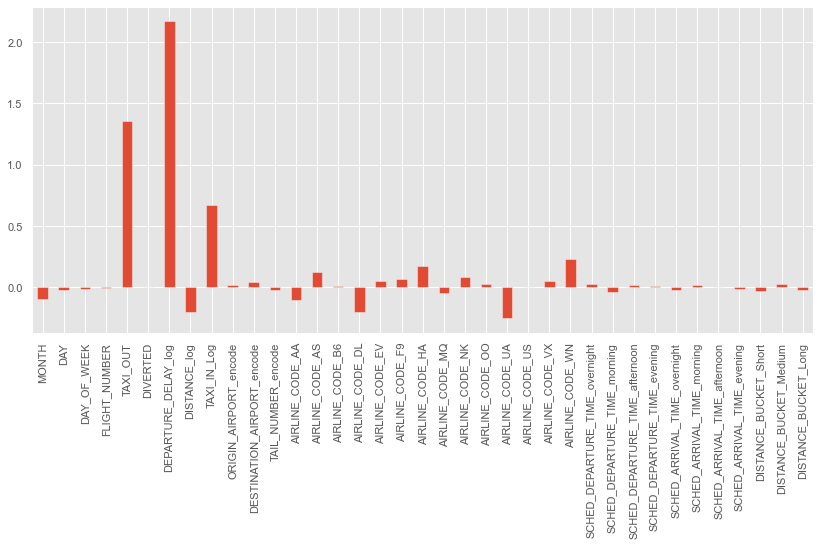

In [60]:
# Now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(14,6))

weights = pd.Series(log_sgd.coef_[0],index=df_weights.columns)
weights.plot(kind='bar')
plt.show()

`TAXI_OUT`, `DEPARTURE_DELAY_log`, and `TAXI_IN_Log` all have very high coefficients. `DIVERTED` has a coefficient of 0 in this model. Let's test re-running logistic regression and feature importance after removing those four variables.

In [61]:
# Remove these variables and create new test/train split
vars_SUB = ['MONTH',
            'DAY',
            'DAY_OF_WEEK',
            'FLIGHT_NUMBER',
            'DISTANCE_log',
            'ORIGIN_AIRPORT_encode',
            'DESTINATION_AIRPORT_encode',
            'TAIL_NUMBER_encode',
            'AIRLINE_CODE_AA',
            'AIRLINE_CODE_AS',
            'AIRLINE_CODE_B6' ,
            'AIRLINE_CODE_DL',
            'AIRLINE_CODE_EV',
            'AIRLINE_CODE_F9',
            'AIRLINE_CODE_HA',
            'AIRLINE_CODE_MQ',
            'AIRLINE_CODE_NK',
            'AIRLINE_CODE_OO',
            'AIRLINE_CODE_UA',
            'AIRLINE_CODE_US' , 
            'AIRLINE_CODE_VX',
            'AIRLINE_CODE_WN',
            'SCHED_DEPARTURE_TIME_overnight',
            'SCHED_DEPARTURE_TIME_morning',
            'SCHED_DEPARTURE_TIME_afternoon',
            'SCHED_DEPARTURE_TIME_evening',
            'SCHED_ARRIVAL_TIME_overnight',
            'SCHED_ARRIVAL_TIME_morning',
            'SCHED_ARRIVAL_TIME_afternoon',
            'SCHED_ARRIVAL_TIME_evening',
            'DISTANCE_BUCKET_Short',
            'DISTANCE_BUCKET_Medium',
            'DISTANCE_BUCKET_Long'
           ]

# We want to predict the X and y data as follows:
if 'DELAYED' in df_final:
    y_sub = df_final['DELAYED'].values # get the labels we want
    X_sub = df_final[vars_SUB].values # use everything else to predict!

In [62]:
X_sub.shape

(5712230, 33)

*Remove items from memory*

In [63]:
del pca_95
del df_pca_95
del df_pca_scaled
del df2
del tempdf
del df
del df_OHE
del X
del y

In [64]:
%%time
num_cv_iterations = 3
num_instances = len(y_sub)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

regularize_const = 0.1
iterations = 5

log_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='log', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X_sub,y_sub):
    log_sgd.fit(scl.fit_transform(X_sub[train_idx]),y_sub[train_idx])
    yhat = log_sgd.predict(scl.transform(X_sub[test_idx]))
    
    conf = mt.confusion_matrix(y_sub[test_idx],yhat)
    acc = mt.accuracy_score(y_sub[test_idx],yhat)

print('Logistic Regression:', acc)

ShuffleSplit(n_splits=3, random_state=10, test_size=0.2, train_size=None)
Logistic Regression: 0.6357394572697528
CPU times: user 56.2 s, sys: 4.04 s, total: 1min
Wall time: 55.9 s


In [65]:
# Iterate over the coefficients and interpret the weights
weights = log_sgd.coef_.T # take transpose to make a column vector
variable_names = df_final[vars_SUB]
for coef, name in zip(weights,variable_names):
    print(name, 'has weight of', coef[0])

MONTH has weight of -0.06748796695099074
DAY has weight of -0.010347042341404935
DAY_OF_WEEK has weight of -0.01975002467419394
FLIGHT_NUMBER has weight of 0.009521269662492293
DISTANCE_log has weight of 0.0016737405374365635
ORIGIN_AIRPORT_encode has weight of 0.025596462316623457
DESTINATION_AIRPORT_encode has weight of 0.036720058472198204
TAIL_NUMBER_encode has weight of -0.015435899512173813
AIRLINE_CODE_AA has weight of -0.007910255953587436
AIRLINE_CODE_AS has weight of -0.0200861504191094
AIRLINE_CODE_B6 has weight of 0.015713928667655388
AIRLINE_CODE_DL has weight of -0.08488460079126667
AIRLINE_CODE_EV has weight of 0.015103553799117717
AIRLINE_CODE_F9 has weight of 0.035551873305621845
AIRLINE_CODE_HA has weight of 0.012280951582891362
AIRLINE_CODE_MQ has weight of 0.0043698904168778
AIRLINE_CODE_NK has weight of 0.054922357317922416
AIRLINE_CODE_OO has weight of 0.014153199844608656
AIRLINE_CODE_UA has weight of 0.0005020732555189725
AIRLINE_CODE_US has weight of 0.00664042

In [66]:
df_weights_2 = df_final[vars_SUB]

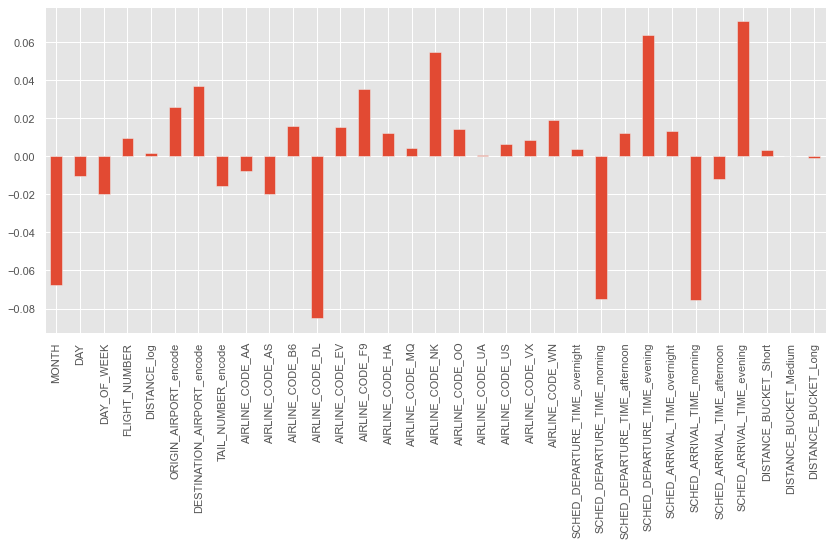

In [67]:
# Now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(14,6))

weights = pd.Series(log_sgd.coef_[0],index=df_weights_2.columns)
weights.plot(kind='bar')
plt.show()

### 1.13 SVM

#### 1.13.1 'Out-of-the-Box' SVM

Note that we have not scaled the data. Our data is all roughly on the same scale to begin with and should not be necessary.

In [68]:
from sklearn.model_selection import ShuffleSplit

# We want to predict the X and y data as follows:
if 'DELAYED' in df_final:
    y = df_final['DELAYED'].values # get the labels we want
    X = df_final.iloc[:,:-1].values # use everything else to predict!

num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,random_state=10,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=10, test_size=0.2, train_size=None)


In [69]:
# use some compact notation for creating a linear SVM classifier with stochastic descent
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import SGDClassifier

regularize_const = 0.1
iterations = 5
svm_sgd = SGDClassifier(alpha=regularize_const,
        fit_intercept=True, l1_ratio=0.0, learning_rate='optimal',
        loss='hinge', n_iter_no_change=iterations, n_jobs=-1, penalty='l2')

scl = StandardScaler()
for train_idx, test_idx in cv_object.split(X,y):
    svm_sgd.fit(scl.fit_transform(X[train_idx]),y[train_idx])
    yhat = svm_sgd.predict(scl.transform(X[test_idx]))
    
    conf = mt.confusion_matrix(y[test_idx],yhat)
    acc = mt.accuracy_score(y[test_idx],yhat)

print('SVM Accuracy:', acc)
print(conf)

SVM Accuracy: 0.8399311652366939
[[676680  48182]
 [134688 282896]]


#### 1.13.2 Using Code From 04. Logits and SVM

Since SVM takes so long to run on the full data set, we sampled 1% of our the records without replacement for the remaining models.

In [71]:
# Sample our data to model off a smaller data set
df_svm_sample = df_final.sample(frac = 0.01, replace = False, random_state = 42)

In [72]:
# We want to predict the X and y data as follows:
if 'DELAYED' in df_svm_sample:
    y = df_svm_sample['DELAYED'].values # get the labels we want
    del df_svm_sample['DELAYED'] # get rid of the class label
    # X = df_svm_sample.values # use everything else to predict!
    X = df_svm_sample.iloc[:,:-1].values # since the above X removes Delayed
    
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [73]:
from sklearn.preprocessing import StandardScaler

# scale attributes by the training set
scl_obj = StandardScaler()
scl_obj.fit(X_train)

StandardScaler()

In [74]:
X_train_scaled = scl_obj.transform(X_train) # apply to training
X_test_scaled = scl_obj.transform(X_test) 

In [75]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set preditions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.860656455142232
[[6774  458]
 [1134 3059]]


In [76]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(16652, 36)
(16652,)
[8440 8212]


#### 1.13.3 SVM with Linear Kernel

Code below is adapted from `04. Logits and SVM.ipynb`.

In [77]:
# Let's investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# Train the model just as before
svm_clf = SVC(C=0.5, kernel='linear', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set preditions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.8533916849015317
[[6698  534]
 [1141 3052]]


In [78]:
# Look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(15882, 36)
(15882,)
[7947 7935]


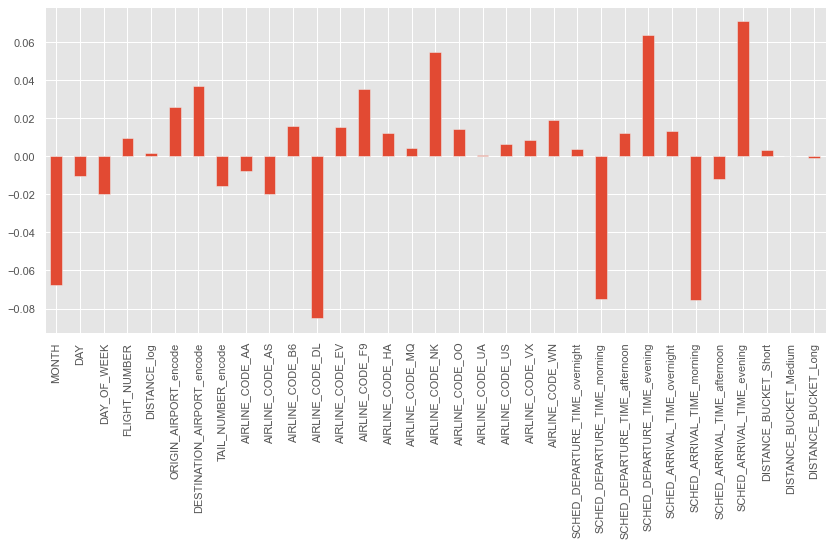

In [80]:
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

plt.figure(figsize=(14,6))

weights = pd.Series(log_sgd.coef_[0],index=df_weights_2.columns)
weights.plot(kind='bar')
plt.show()

In [81]:
svm_clf.support_vectors_

array([[ 1.02216406, -1.21403859, -1.48477526, ...,  1.0846962 ,
        -0.10780651,  0.64599754],
       [-1.63371504, -1.44190207,  1.03117988, ..., -0.92191712,
        -0.10780651,  0.64599754],
       [-1.33861736,  1.06459621, -0.4783932 , ...,  1.0846962 ,
        -0.10780651, -1.54799351],
       ...,
       [-0.74842201, -0.98617511, -0.98158423, ...,  1.0846962 ,
        -0.10780651,  0.64599754],
       [-0.45332433,  0.03921055,  1.03117988, ..., -0.92191712,
        -0.10780651, -1.54799351],
       [ 0.4319687 ,  1.29245968,  0.02479782, ...,  1.0846962 ,
        -0.10780651,  0.64599754]])

In [82]:
# Now let's do some different analysis with the SVM and look at the instances that were chosen as support vectors

# now lets look at the support for the vectors and see if we they are indicative of anything
# grabe the rows that were selected as support vectors (these are usually instances that are hard to classify)

# make a dataframe of the training data
# df_tested_on = df_svm_sample.iloc[train_indices].copy() # saved from above, the indices chosen for training
df_tested_on = df_svm_sample.iloc[:,:-1].copy() # saved from above, the indices chosen for training

# now get the support vectors from the trained model
df_support = df_tested_on.iloc[svm_clf.support_,:].copy()

df_support['DELAYED'] = y[svm_clf.support_] # add back in the 'Survived' Column to the pandas dataframe
df_svm_sample['DELAYED'] = y # also add it back in for the original data
df_support.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15882 entries, 5029127 to 1216372
Data columns (total 37 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   MONTH                           15882 non-null  int64  
 1   DAY                             15882 non-null  int64  
 2   DAY_OF_WEEK                     15882 non-null  int64  
 3   FLIGHT_NUMBER                   15882 non-null  int64  
 4   TAXI_OUT                        15882 non-null  float64
 5   DIVERTED                        15882 non-null  int64  
 6   DEPARTURE_DELAY_log             15882 non-null  float64
 7   DISTANCE_log                    15882 non-null  float64
 8   TAXI_IN_Log                     15882 non-null  float64
 9   ORIGIN_AIRPORT_encode           15882 non-null  int64  
 10  DESTINATION_AIRPORT_encode      15882 non-null  float64
 11  TAIL_NUMBER_encode              15882 non-null  int64  
 12  AIRLINE_CODE_AA         

/Users/mattfarrow/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


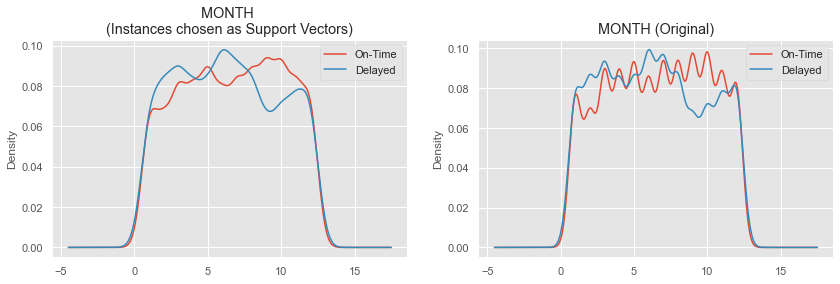

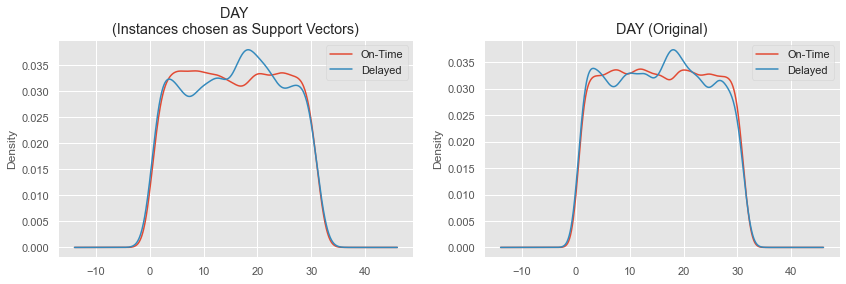

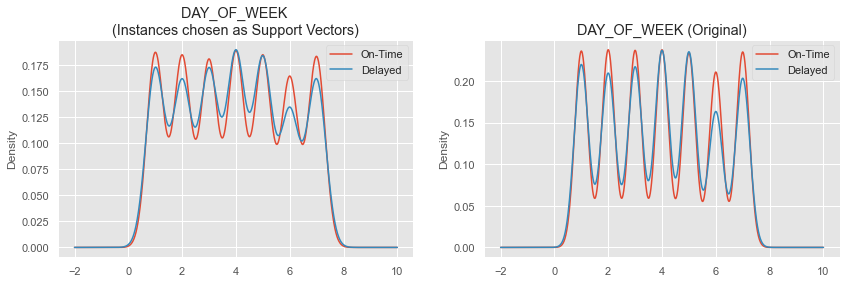

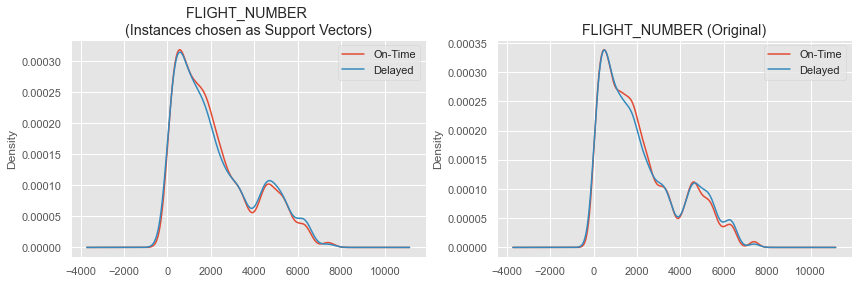

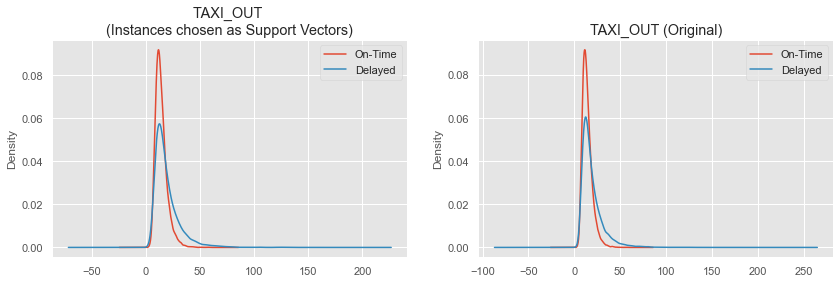

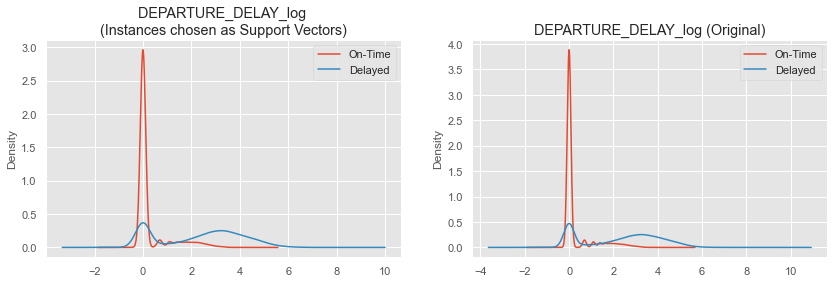

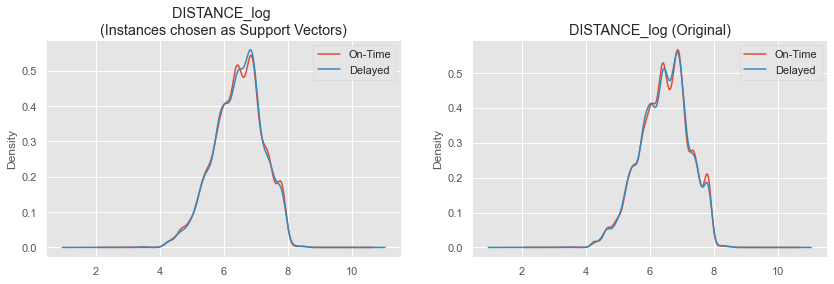

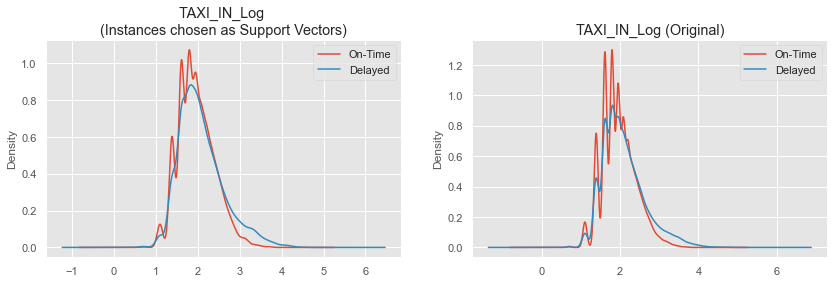

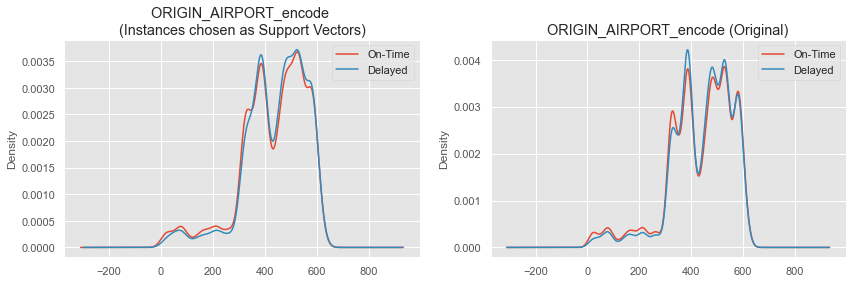

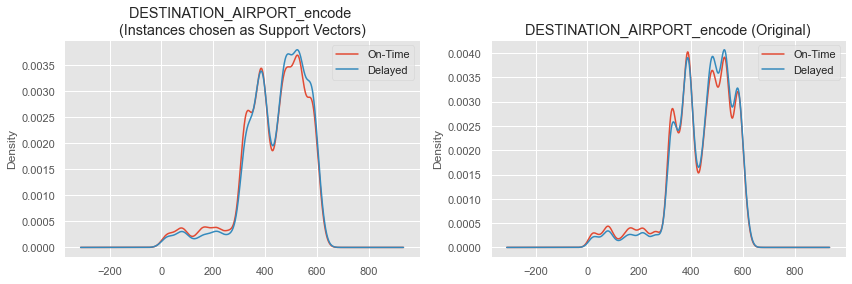

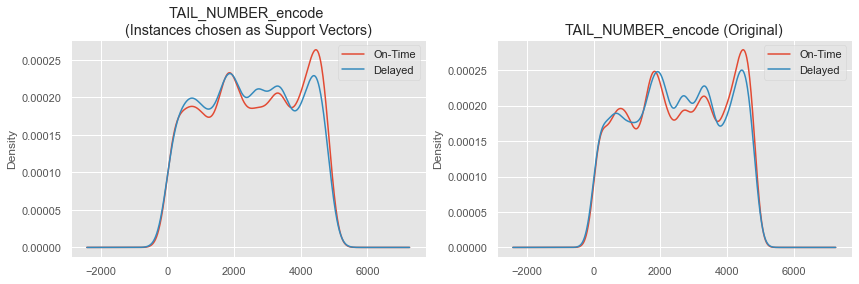

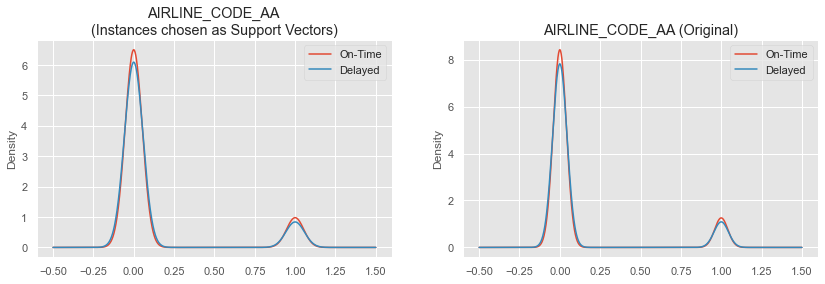

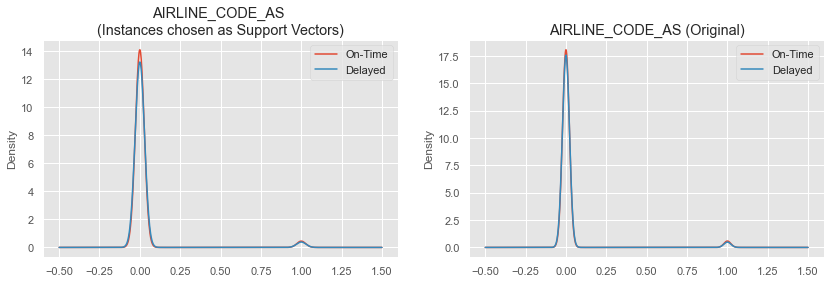

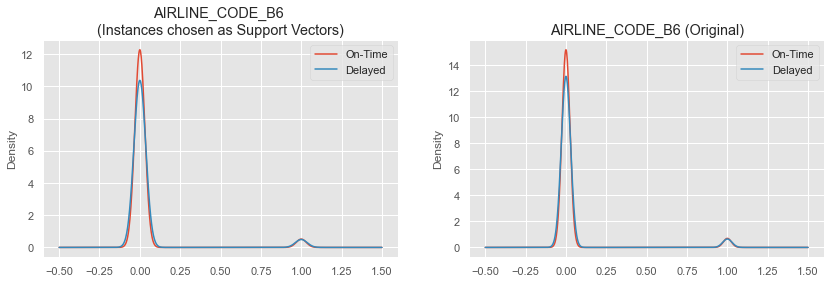

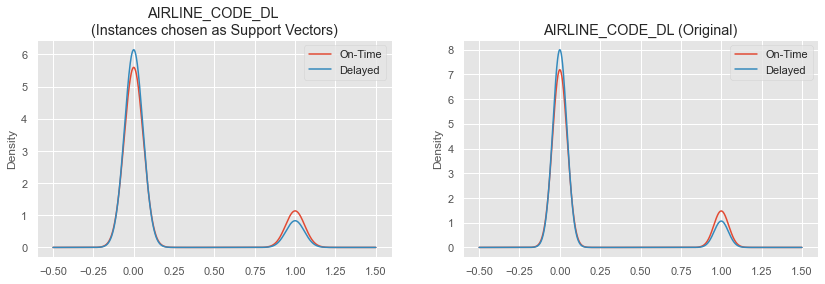

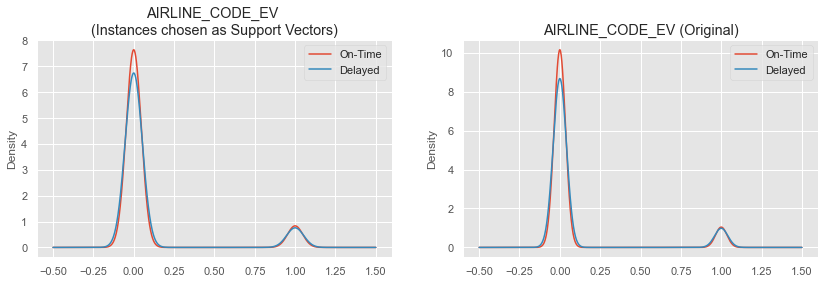

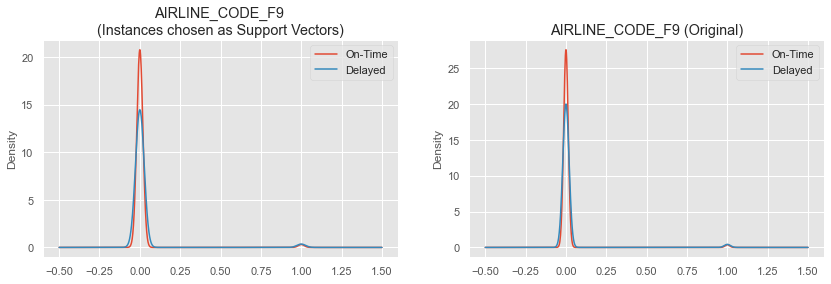

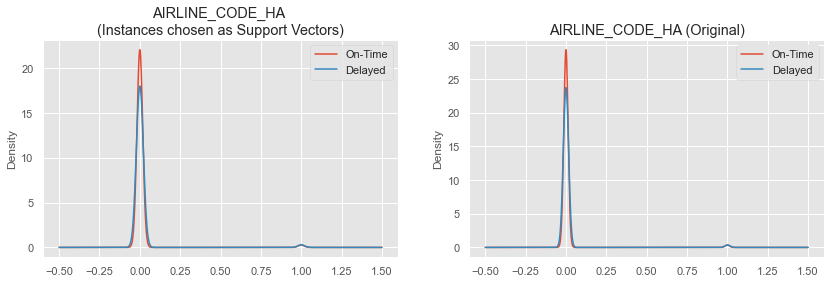

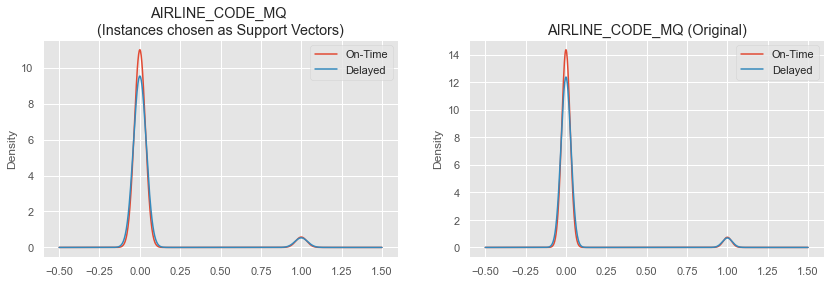

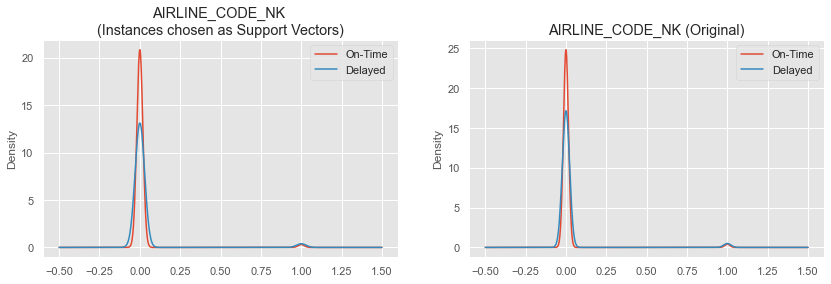

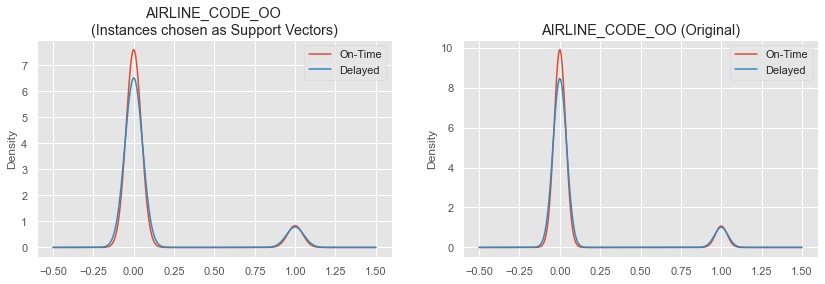

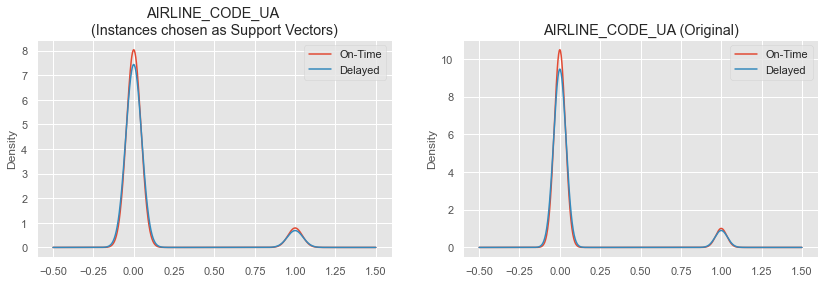

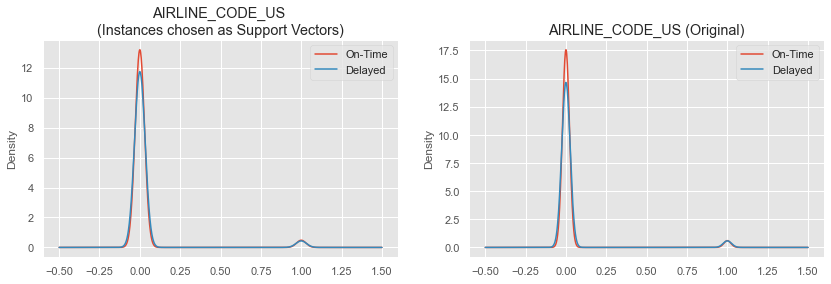

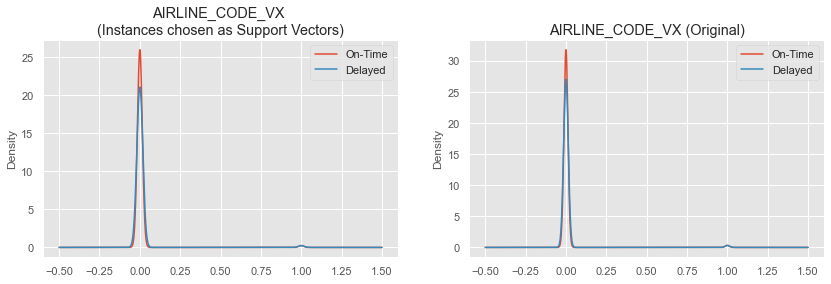

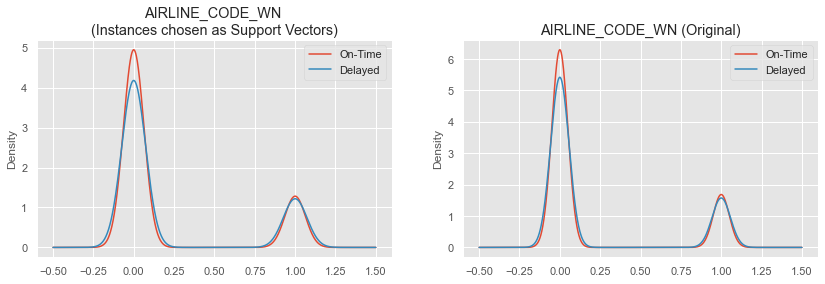

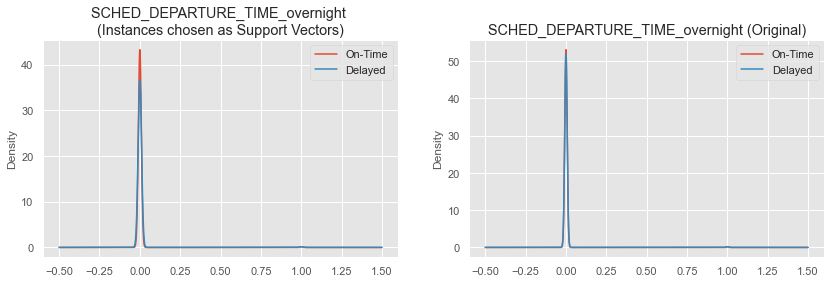

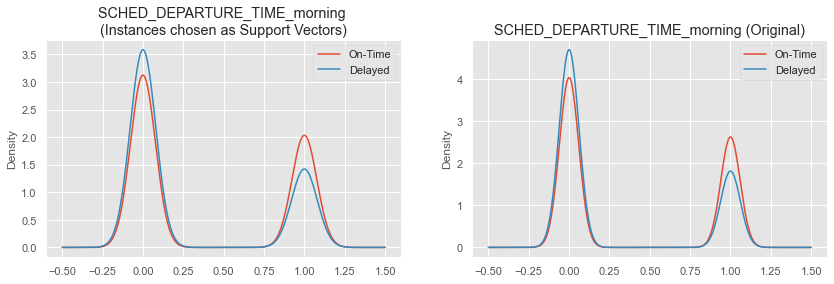

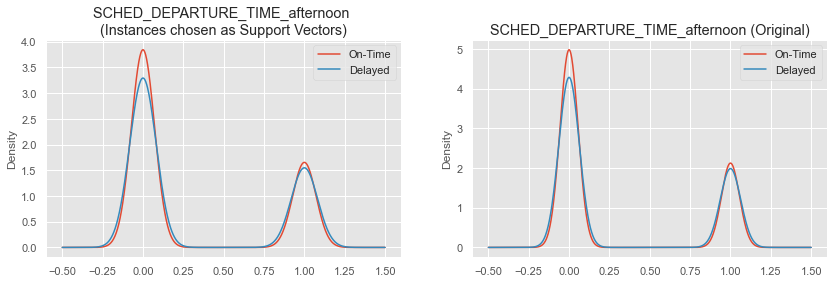

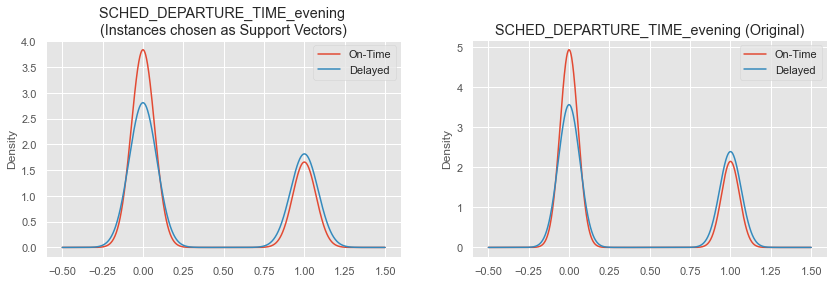

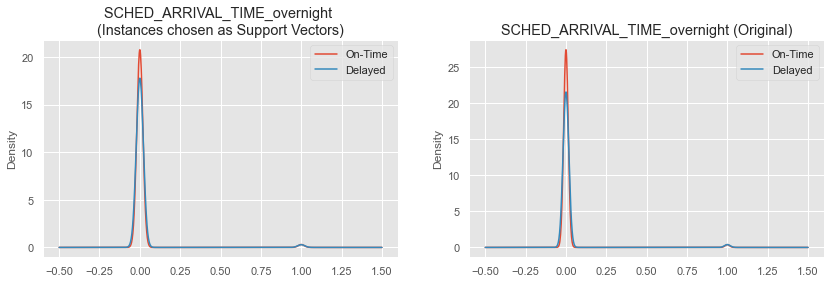

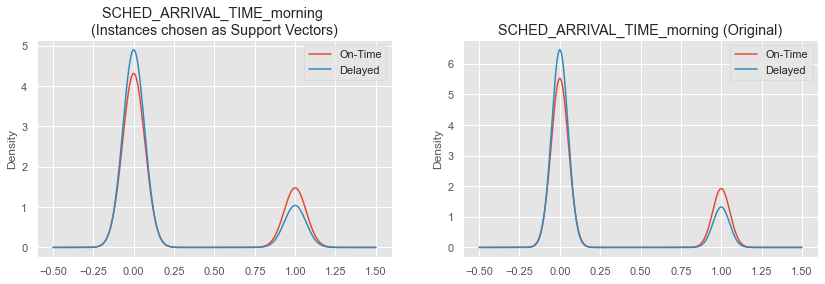

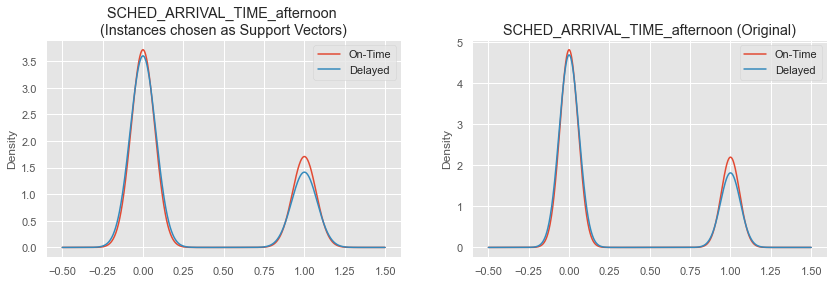

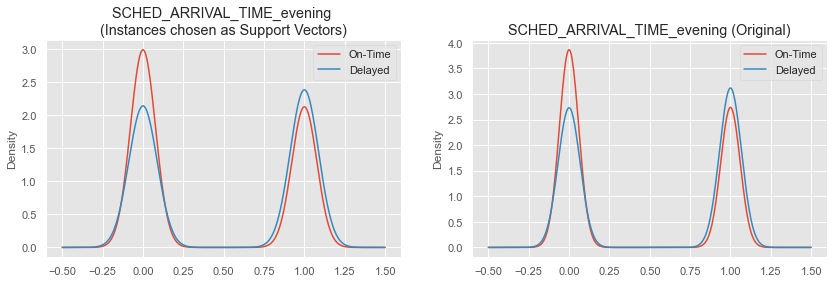

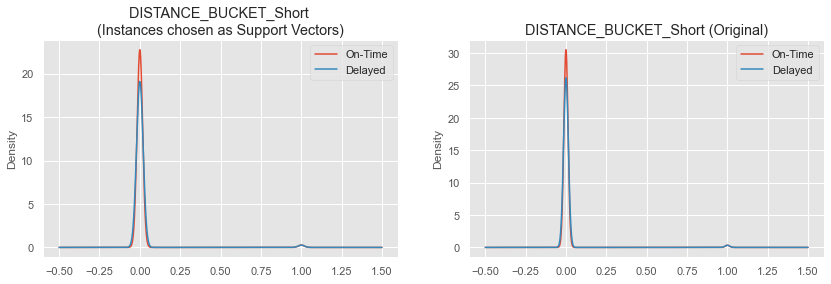

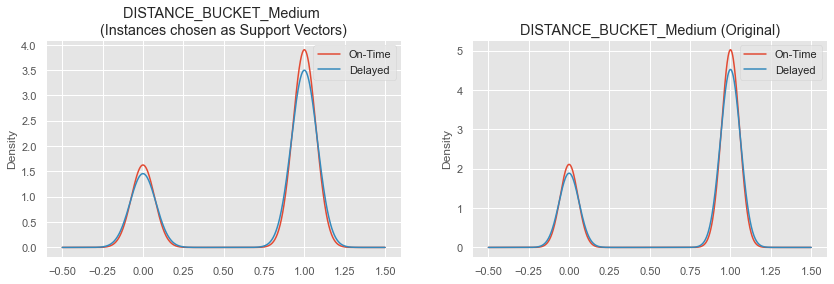

In [84]:
# now lets see the statistics of these attributes
from pandas.plotting import boxplot

# group the original data and the support vectors
df_grouped_support = df_support.groupby(['DELAYED'])
df_grouped = df_svm_sample.groupby(['DELAYED'])

# plot KDE of Different variables
vars_to_plot = ['MONTH',
                'DAY',
                'DAY_OF_WEEK',
                'FLIGHT_NUMBER',
                'TAXI_OUT',
                'DEPARTURE_DELAY_log',
                'DISTANCE_log',
                'TAXI_IN_Log',
                'ORIGIN_AIRPORT_encode',
                'DESTINATION_AIRPORT_encode',
                'TAIL_NUMBER_encode',
                'AIRLINE_CODE_AA',
                'AIRLINE_CODE_AS',
                'AIRLINE_CODE_B6' ,
                'AIRLINE_CODE_DL',
                'AIRLINE_CODE_EV',
                'AIRLINE_CODE_F9',
                'AIRLINE_CODE_HA',
                'AIRLINE_CODE_MQ',
                'AIRLINE_CODE_NK',
                'AIRLINE_CODE_OO',
                'AIRLINE_CODE_UA',
                'AIRLINE_CODE_US' , 
                'AIRLINE_CODE_VX',
                'AIRLINE_CODE_WN',
                'SCHED_DEPARTURE_TIME_overnight',
                'SCHED_DEPARTURE_TIME_morning',
                'SCHED_DEPARTURE_TIME_afternoon',
                'SCHED_DEPARTURE_TIME_evening',
                'SCHED_ARRIVAL_TIME_overnight',
                'SCHED_ARRIVAL_TIME_morning',
                'SCHED_ARRIVAL_TIME_afternoon',
                'SCHED_ARRIVAL_TIME_evening',
                'DISTANCE_BUCKET_Short',
                'DISTANCE_BUCKET_Medium'
               ]

for v in vars_to_plot:
    plt.figure(figsize=(14,4))
    # plot support vector stats
    plt.subplot(1,2,1)
    ax = df_grouped_support[v].plot.kde() 
    plt.legend(['On-Time','Delayed'])
    plt.title(v+' \n(Instances chosen as Support Vectors)')
    
    # plot original distributions
    plt.subplot(1,2,2)
    ax = df_grouped[v].plot.kde() 
    plt.legend(['On-Time','Delayed'])
    plt.title(v+' (Original)')


## 2. Advantages of Each Model

> **[10 points]** Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.

Our analysis shows that logistic regression model offered 2% better model accuracy than SVM. This is expected since our data is structured and has identifiable variables, which is better for logistic regression. The logistic regression accuracy is 0.85 for all three iterations (0.8557874945511648, 0.8545856872009705, and 0.8548123937586547), whereas the SVM accuracy was 0.8399. 

SVM also utilized more computationally than logistic regression and took significantly longer to process. We found grid search as part of feature selection to be both time consuming to process, but also required significant computational resources. Grid search crashed due to max resources several times. 

Both models were reasonably fast to build overall, but, considering accuracy, time and computational processing, for our data set, logistic regression is better.

## 3. Feature Importance

> **[30 points]** Use the weights from logistic regression to interpret the importance of different features for each classification task. Explain your interpretation in detail. Why do you think some variables are more important?

### 3.1 Weights (Ordered)

| Variable                       | Coefficient  |
|--------------------------------|--------------|
| MONTH                          | -0.038797599 |
| DAY                            | -0.004623126 |
| DAY_OF_WEEK                    | -0.043852471 |
| FLIGHT_NUMBER                  | -7.59741E-05 |
| TAXI_OUT                       | 0.144409121  |
| DIVERTED                       | 0            |
| DEPARTURE_DELAY_log            | 1.383507196  |
| DISTANCE_log                   | -0.783440119 |
| TAXI_IN_Log                    | 1.264014238  |
| ORIGIN_AIRPORT_encode          | -0.000175709 |
| DESTINATION_AIRPORT_encode     | -5.47095E-05 |
| TAIL_NUMBER_encode             | -5.58957E-05 |
| AIRLINE_CODE_AA                | -0.299386121 |
| AIRLINE_CODE_AS                | 0.259878467  |
| AIRLINE_CODE_B6                | -0.084707295 |
| AIRLINE_CODE_DL                | -0.610397408 |
| AIRLINE_CODE_EV                | 0.062029928  |
| AIRLINE_CODE_F9                | 0.136878861  |
| AIRLINE_CODE_HA                | 0.161936974  |
| AIRLINE_CODE_MQ                | -0.141978443 |
| AIRLINE_CODE_NK                | 0.16124127   |
| AIRLINE_CODE_OO                | 0.107738791  |
| AIRLINE_CODE_UA                | -0.644212585 |
| AIRLINE_CODE_US                | -0.02960251  |
| AIRLINE_CODE_VX                | 0.079051418  |
| AIRLINE_CODE_WN                | 0.453810909  |
| SCHED_DEPARTURE_TIME_overnight | 0.020685601  |
| SCHED_DEPARTURE_TIME_morning   | -0.183262094 |
| SCHED_DEPARTURE_TIME_a         | -0.073692099 |
| SCHED_DEPARTURE_TIME_evening   | -0.151449152 |
| SCHED_ARRIVAL_TIME_overnight   | -0.033014929 |
| SCHED_ARRIVAL_TIME_morning     | -0.111094197 |
| SCHED_ARRIVAL_TIME_a           | -0.130313281 |
| SCHED_ARRIVAL_TIME_evening     | -0.113295337 |
| DISTANCE_BUCKET_Short          | -0.13067606  |
| DISTANCE_BUCKET_Medium         | -0.386151629 |
| DISTANCE_BUCKET_Long           | 0.129109945  |

### Weights (Largest to Smallest)

| Variable                       | Coefficient  |
|--------------------------------|--------------|
| DEPARTURE_DELAY_log            | 1.383507196  |
| TAXI_IN_Log                    | 1.264014238  |
| AIRLINE_CODE_WN                | 0.453810909  |
| AIRLINE_CODE_AS                | 0.259878467  |
| AIRLINE_CODE_HA                | 0.161936974  |
| AIRLINE_CODE_NK                | 0.16124127   |
| TAXI_OUT                       | 0.144409121  |
| AIRLINE_CODE_F9                | 0.136878861  |
| DISTANCE_BUCKET_Long           | 0.129109945  |
| AIRLINE_CODE_OO                | 0.107738791  |
| AIRLINE_CODE_VX                | 0.079051418  |
| AIRLINE_CODE_EV                | 0.062029928  |
| SCHED_DEPARTURE_TIME_overnight | 0.020685601  |
| DIVERTED                       | 0            |
| DESTINATION_AIRPORT_encode     | -5.47095E-05 |
| TAIL_NUMBER_encode             | -5.58957E-05 |
| FLIGHT_NUMBER                  | -7.59741E-05 |
| ORIGIN_AIRPORT_encode          | -0.000175709 |
| DAY                            | -0.004623126 |
| AIRLINE_CODE_US                | -0.02960251  |
| SCHED_ARRIVAL_TIME_overnight   | -0.033014929 |
|        MONTH                   | -0.038797599 |
| DAY_OF_WEEK                    | -0.043852471 |
| SCHED_DEPARTURE_TIME_a         | -0.073692099 |
| AIRLINE_CODE_B6                | -0.084707295 |
| SCHED_ARRIVAL_TIME_morning     | -0.111094197 |
| SCHED_ARRIVAL_TIME_evening     | -0.113295337 |
| SCHED_ARRIVAL_TIME_a           | -0.130313281 |
| DISTANCE_BUCKET_Short          | -0.13067606  |
| AIRLINE_CODE_MQ                | -0.141978443 |
| SCHED_DEPARTURE_TIME_evening   | -0.151449152 |
| SCHED_DEPARTURE_TIME_morning   | -0.183262094 |
| AIRLINE_CODE_AA                | -0.299386121 |
| DISTANCE_BUCKET_Medium         | -0.386151629 |
| AIRLINE_CODE_DL                | -0.610397408 |
| AIRLINE_CODE_UA                | -0.644212585 |
| DISTANCE_log                   | -0.783440119 |

## 4. Support Vectors

> **[10 points]** Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain.

We reviewed support vectors for `DELAYED` where **0** represents Not Delayed and **1** represents Delayed. The number of support vectors in this liner model was 15,823, out of the 5,712,239 which only accounts for ~0.2% of data which is a low subset of our original data. Out of this subset of data, when reviewing Support vectors `TAXI_OUT`, `DEPARTURE_DELAY_log`, and `TAXI_IN_Log` stood out as these features did not do well in preserving original data integrity.

`Taxi_out`

Had a similar shape however it did not represent the spike shown in Not Delayed in the original data set which has the highest peak of 0.9 on the Y axis while the SVM has little to no variation.

`DEPARTURE_DELAY_log`

There is not a peak with the same intensity as in original data set. The overall shape is similar but does have some distinct areas in the X axis (starting at 2.5 and ending at 5.0 in the original data set) where it does not follow the same pattern.

`TAXI_IN_Log`

The shape in the SVM Model did not fit the original data set. There should have been more of a difference between Delayed and Not Delayed as seen above the in the original data `Delayed` does not marry up to `Not Delayed` as is shown in SVM this clearly shows a clear discrepancy between the two.

For support vectors models, this is not highly surprising since “support vectors tend to be instances on the edge of the class boundaries and also instances that are classified incorrectly in the training data.” ***– per DataMiningNotebook/Logits and SVM.ipynb.*** Overall for the majority of the features in the SVM did keep the integrity of the original data with these few key exceptions.